<a href="https://colab.research.google.com/github/qonitah-sarah/predict-transactions-next-month/blob/main/Berapa_Banyak_Transaksi_yang_Akan_Terjadi_dalam_Satu_Bulan_ke_Depan%3F_Prediksi_Jumlah_Transaksi_dengan_Model_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Package

In [ ]:
!pip install --upgrade pip
!pip install scikit-learn==1.3.0
!pip install sktime==0.25.0
!pip install pmdarima

In [ ]:
# utilities packages
import datetime

# data wrangling and transformation package
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import statsmodels.api as sm

# data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# time series modeling
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.stats.diagnostic import acorr_ljungbox

# load sktime for time series forecasting
from sktime.utils.plotting import plot_series # from plotting
from sktime.forecasting.naive import NaiveForecaster # for naive forecasting
from sktime.forecasting.arima import AutoARIMA # for automated ARIMA forecasting
from sktime.forecasting.exp_smoothing import ExponentialSmoothing # for exponential smoothing forecasting
from sktime.forecasting.ets import AutoETS # for automated ETS forecasting
from sktime.forecasting.tbats import TBATS # for TBATS forecasting
from sktime.forecasting.fbprophet import Prophet # for Prophet forecasting
from sktime.forecasting.base import ForecastingHorizon # for creating forecast horizon
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ExpandingWindowSplitter,
    SlidingWindowSplitter
) # for train-test split and cross validation
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
) # for evaluation metrics
from sktime.forecasting.model_evaluation import evaluate # for evaluating CV results

%matplotlib inline

## Data Understanding

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/time_series_data/superstore_time_series_dataset/superstore_train.csv')

Metadata dari dataset yang akan dianalisis:
- Row ID - Nomor urut
- Order ID - ID yang dibuat ketika pesanan produk ditempatkan
- Order Date - Tanggal pelanggan menempatkan pesanannya
- Ship Date - Tanggal pesanan dikirim.
-	Ship Mode - Moda pengiriman setiap pesanan.
-	Customer ID - ID pelanggan.
-	Customer Name - Nama pelanggan.
-	Segment - Segmen pelanggan.
-	Country - Negara (fokus pada data toko AS).
-	City - Kota tempat transaksi terjadi.
-	State - Negara bagian tempat transaksi terjadi.
-	Postal Code - Kode pos.
-	Region - Wilayah tempat transaksi terjadi.
-	Product ID - ID setiap produk.
-	Category - Kategori produk.
-	Sub-Category - Sub-kategori produk.
-	Product Name - Nama produk.
-	Sales - Harga jual produk.
-	Quantity - Jumlah produk yang terjual.
-	Discount - Diskon pada setiap produk.
-	Profit - Keuntungan yang diperoleh dari penjualan.


In [ ]:
# menampilkan 5 baris pertama
df.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688  2016-06-12  2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0        42420  South  FUR-BO-10001798        Furniture    Bookcases   
1        42420  South  FUR-CH-10000454        Furniture       Chairs   
2        90036   West  OFF-LA-10000240  Office Supplies       Labels   
3        33311  South  FUR-TA-10000577        Furniture       Tables   
4        33311  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164

In [ ]:
# menampilkan 5 baris terbawah
df.tail()

Row ID        Order ID  Order Date   Ship Date     Ship Mode  \
7995    7996  US-2015-165743  2015-11-20  2015-11-23  Second Class   
7996    7997  US-2017-105998  2017-11-03  2017-11-05   First Class   
7997    7998  US-2017-105998  2017-11-03  2017-11-05   First Class   
7998    7999  US-2014-148194  2014-05-04  2014-05-07   First Class   
7999    8000  US-2014-148194  2014-05-04  2014-05-07   First Class   

     Customer ID   Customer Name      Segment        Country       City  \
7995    MM-18055  Michelle Moray     Consumer  United States     Aurora   
7996    CR-12580   Clay Rozendal  Home Office  United States  San Diego   
7997    CR-12580   Clay Rozendal  Home Office  United States  San Diego   
7998    BS-11365    Bill Shonely    Corporate  United States    Seattle   
7999    BS-11365    Bill Shonely    Corporate  United States    Seattle   

           State  Postal Code Region       Product ID         Category  \
7995    Colorado        80013   West  OFF-BI-10001758  Office Supplies   
7996  California        92037   West  TEC-AC-10004469       Technology   
7997  California        92037   West  FUR-TA-10001095        Furniture   
7998  Washington        98105   West  FUR-FU-10001852        Furniture   
7999  Washington        98105   West  OFF-AP-10000696  Office Supplies   

     Sub-Category                                       Product Name  \
7995      Binders  Wilson Jones 14 Line Acrylic Coated Pressboard...   
7996  Accessories                     Microsoft Sculpt Comfort Mouse   
7997       Tables                 Chromcraft Round Conference Tables   
7998  Furnishings  Eldon Regeneration Recycled Desk Accessories, ...   
7999   Appliances                                Holmes Odor Grabber   

         Sales  Quantity  Discount   Profit  
7995     9.612         6       0.7  -7.3692  
7996   199.750         5       0.0  87.8900  
7997  1673.184        12       0.2  20.9148  
7998    12.180         7       0.0   3.8976  
7999    57.680         4       0.0  19.0344

In [ ]:
# melihat 5 baris secara acak
df.sample(5)

Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
2018    2019  CA-2015-113110  2015-03-19  2015-03-23  Standard Class   
2770    2771  US-2015-122140  2015-04-02  2015-04-07  Standard Class   
5960    5961  CA-2017-150602  2017-02-09  2017-02-14    Second Class   
412      413  CA-2017-117457  2017-12-08  2017-12-12  Standard Class   
475      476  CA-2014-144666  2014-11-09  2014-11-11    Second Class   

     Customer ID        Customer Name    Segment        Country  \
2018    BK-11260       Berenike Kampe   Consumer  United States   
2770    MO-17950       Michael Oakman   Consumer  United States   
5960    ML-17395  Marina Lichtenstein  Corporate  United States   
412     KH-16510        Keith Herrera   Consumer  United States   
475     JP-15520        Jeremy Pistek   Consumer  United States   

                City       State  Postal Code   Region       Product ID  \
2018  San Bernardino  California        92404     West  OFF-SU-10001165   
2770          Dallas       Texas        75220  Central  TEC-AC-10003289   
5960     Los Angeles  California        90045     West  FUR-FU-10003142   
412    San Francisco  California        94110     West  FUR-BO-10001972   
475    San Francisco  California        94110     West  OFF-PA-10001509   

             Category Sub-Category  \
2018  Office Supplies     Supplies   
2770       Technology  Accessories   
5960        Furniture  Furnishings   
412         Furniture    Bookcases   
475   Office Supplies        Paper   

                                           Product Name     Sales  Quantity  \
2018                Acme Elite Stainless Steel Scissors    33.360         4   
2770  Anker Ultra-Slim Mini Bluetooth 3.0 Wireless K...    47.976         3   
5960                    Master Big Foot Doorstop, Beige    21.120         4   
412          O'Sullivan 4-Shelf Bookcase in Odessa Pine  1336.829        13   
475   Recycled Desk Saver Line "While You Were Out" ...    62.650         7   

      Discount   Profit  
2018      0.00   8.6736  
2770      0.20   1.7991  
5960      0.00   6.5472  
412       0.15  31.4548  
475       0.00  28.8190

In [ ]:
df.shape

(8000, 21)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         8000 non-null   int64  
 1   Order ID       8000 non-null   object 
 2   Order Date     8000 non-null   object 
 3   Ship Date      8000 non-null   object 
 4   Ship Mode      8000 non-null   object 
 5   Customer ID    8000 non-null   object 
 6   Customer Name  8000 non-null   object 
 7   Segment        8000 non-null   object 
 8   Country        8000 non-null   object 
 9   City           8000 non-null   object 
 10  State          8000 non-null   object 
 11  Postal Code    8000 non-null   int64  
 12  Region         8000 non-null   object 
 13  Product ID     8000 non-null   object 
 14  Category       8000 non-null   object 
 15  Sub-Category   8000 non-null   object 
 16  Product Name   8000 non-null   object 
 17  Sales          8000 non-null   float64
 18  Quantity

Observasi:
- Data merupakan histori transaksi penjualan dengan jumlah 21 kolom dan 8000 baris
- Secara garis besar data terdiri dari info mengenai identitas pelanggan, produk yang dibeli, beserta detail harganya
- Seluruh tipe data telah sesuai kecuali pada `Order Date` dan `Ship Date` yang perlu dikoreksi formatnya menjadi lebih sesuai menjadi datetime

In [ ]:
# mengubah tipe data kolom 'Order Date' dan 'Ship Date'
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [ ]:
# mengekstrak bulan, tahun, dan jam dari kolom 'Order Date'
df['Month'] = df['Order Date'].dt.month
df['Year'] = df['Order Date'].dt.year
df['Time'] = df['Order Date'].dt.time

In [ ]:
# mengelompokkan kolom numerikal dan kategorikal ke dala variabel terpisah untuk memudahkan analisis ke depannya
numericals = df.select_dtypes(include = ['int', 'float'])

categoricals = df.select_dtypes(include = ['object'])

Observasi:
- `Order Date` dan `Ship Date` telah berhasil menjadi format datetime
- Melakukan ekstrak bulan, tahun, dan waktu dari kolom `Order Date`

### Descriptive Statistics

In [ ]:
numericals.describe()

Row ID   Postal Code         Sales     Quantity     Discount  \
count  8000.00000   8000.000000   8000.000000  8000.000000  8000.000000   
mean   4000.50000  55225.850000    229.823459     3.786875     0.152864   
std    2309.54541  32049.060112    621.031927     2.211349     0.203951   
min       1.00000   1040.000000      0.444000     1.000000     0.000000   
25%    2000.75000  22980.000000     17.340000     2.000000     0.000000   
50%    4000.50000  55901.000000     54.352000     3.000000     0.150000   
75%    6000.25000  90008.000000    211.870000     5.000000     0.200000   
max    8000.00000  99301.000000  22638.480000    14.000000     0.800000   

            Profit        Month         Year  
count  8000.000000  8000.000000  8000.000000  
mean     28.134233     7.856625  2015.726375  
std     227.328814     3.262652     1.123571  
min   -6599.978000     1.000000  2014.000000  
25%       1.814700     5.000000  2015.000000  
50%       8.765100     9.000000  2016.000000  
75%      29.950500    11.000000  2017.000000  
max    8399.976000    12.000000  2017.000000

Observasi:
- Tidak terdapat masalah pada angka minimal dan maksimal di setiap kolom numerikal
- Nilai rata-rata dan median pada `Sales` cukup jauh, diperkirakan distribusi data akan berbentuk skew karena dipengaruhi oleh nilai outlier

In [ ]:
categoricals.describe()

Order ID       Ship Mode Customer ID Customer Name   Segment  \
count             8000            8000        8000          8000      8000   
unique            3962               4         784           784         3   
top     CA-2017-100111  Standard Class    JL-15835      John Lee  Consumer   
freq                14            4788          33            33      4192   

              Country           City       State Region       Product ID  \
count            8000           8000        8000   8000             8000   
unique              1            502          49      4             1831   
top     United States  New York City  California   West  TEC-AC-10002049   
freq             8000            743        1608   2605               15   

               Category Sub-Category Product Name      Time  
count              8000         8000         8000      8000  
unique                3           17         1819         1  
top     Office Supplies      Binders      Staples  00:00:00  
freq               4840         1214           43      8000

In [ ]:
# Showing the percentage of each unique value in categorial columns
# By value counts
for cc in categoricals:
    print(f"Value counts of {cc} columns")
    print(df[cc].value_counts(normalize = True), '\n')

Output streaming akan dipotong hingga 5000 baris terakhir.
Jim Epp                   0.002375
Steve Nguyen              0.002375
Mick Hernandez            0.002375
Barry Französisch         0.002375
Peter Fuller              0.002375
Joe Kamberova             0.002375
Sung Pak                  0.002375
Nick Zandusky             0.002375
Sanjit Chand              0.002375
Anna Häberlin             0.002375
Logan Haushalter          0.002375
Chris Cortes              0.002375
Herbert Flentye           0.002375
Maria Etezadi             0.002250
Dean Katz                 0.002250
Katherine Murray          0.002250
Katharine Harms           0.002250
Sue Ann Reed              0.002250
Sanjit Jacobs             0.002250
Chuck Clark               0.002250
Helen Andreada            0.002250
Stewart Carmichael        0.002250
Shahid Collister          0.002250
Dennis Kane               0.002250
Tracy Blumstein           0.002250
Tim Brockman              0.002250
Maxwell Schwartz          0.002

Observasi:
- Pelanggan didominasi lebih 50% menggunakan layanan `Ship Mode` Standard Class
- Pelanggan mendominasi lebih 50% sebagai segmen **Consumer**
- `Country` hanya diisi oleh 1 negara yaitu **United States**
- **Office Supplies** adalah kategori barang yang banyak muncul

### Checking Duplicate Value

In [ ]:
# duplicated
len(df.drop_duplicates())/len(df)

1.0

Observasi:
- Tidak terdapat nilai duplikat pada data

### Checking Missing Value

In [ ]:
# missing_value
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
Month            0
Year             0
Time             0
dtype: int64

In [ ]:
for columns in df.columns:
    print(f"============= {columns} =================")
    display(df[columns].value_counts())
    print()

============= Row ID =================


Row ID
1       1
5330    1
5343    1
5342    1
5341    1
5340    1
5339    1
5338    1
5337    1
5336    1
5335    1
5334    1
5333    1
5332    1
5331    1
5329    1
5314    1
5328    1
5327    1
5326    1
5325    1
5324    1
5323    1
5322    1
5321    1
5320    1
5319    1
5318    1
5317    1
5316    1
5344    1
5345    1
5346    1
5347    1
5374    1
5373    1
5372    1
5371    1
5370    1
5369    1
5368    1
5367    1
5366    1
5365    1
5364    1
5363    1
5362    1
5361    1
5360    1
5359    1
5358    1
5357    1
5356    1
5355    1
5354    1
5353    1
5352    1
5351    1
5350    1
5349    1
5348    1
5315    1
5313    1
2       1
5267    1
5280    1
5279    1
5278    1
5277    1
5276    1
5275    1
5274    1
5273    1
5272    1
5271    1
5270    1
5269    1
5268    1
5266    1
5312    1
5265    1
5264    1
5263    1
5262    1
5261    1
5260    1
5259    1
5258    1
5257    1
5256    1
5255    1
5254    1
5253    1
5281    1
5282    1
5283    1
5284    1
5311    1
5310    1
5309    1
5308    1
5307    1
5306    1
5305    1
5304    1
5303    1
5302    1
5301    1
5300    1
5299    1
5298    1
5297    1
5296    1
5295    1
5294    1
5293    1
5292    1
5291    1
5290    1
5289    1
5288    1
5287    1
5286    1
5285    1
5375    1
5376    1
5377    1
5455    1
5468    1
5467    1
5466    1
5465    1
5464    1
5463    1
5462    1
5461    1
5460    1
5459    1
5458    1
5457    1
5456    1
5454    1
5378    1
5453    1
5452    1
5451    1
5450    1
5449    1
5448    1
5447    1
5446    1
5445    1
5444    1
5443    1
5442    1
5441    1
5469    1
5470    1
5471    1
5472    1
5499    1
5498    1
5497    1
5496    1
5495    1
5494    1
5493    1
5492    1
5491    1
5490    1
5489    1
5488    1
5487    1
5486    1
5485    1
5484    1
5483    1
5482    1
5481    1
5480    1
5479    1
5478    1
5477    1
5476    1
5475    1
5474    1
5473    1
5440    1
5439    1
5438    1
5407    1
5405    1
5404    1
5403    1
5402    1
5401    1
5400    1
5399    1
5398    1
5397    1
5396    1
5395    1
5394    1
5393    1
5392    1
5391    1
5390    1
5389    1
5388    1
5387    1
5386    1
5385    1
5384    1
5383    1
5382    1
5381    1
5380    1
5379    1
5406    1
5408    1
5437    1
5409    1
5436    1
5435    1
5434    1
5433    1
5432    1
5431    1
5430    1
5429    1
5428    1
5427    1
5426    1
5425    1
5424    1
5423    1
5422    1
5421    1
5420    1
5419    1
5418    1
5417    1
5416    1
5415    1
5414    1
5413    1
5412    1
5411    1
5410    1
5252    1
5251    1
5250    1
5079    1
5092    1
5091    1
5090    1
5089    1
5088    1
5087    1
5086    1
5085    1
5084    1
5083    1
5082    1
5081    1
5080    1
5078    1
5125    1
5077    1
5076    1
5075    1
5074    1
5073    1
5072    1
5071    1
5070    1
5069    1
5068    1
5067    1
5066    1
5065    1
5093    1
5094    1
5095    1
5096    1
5123    1
5122    1
5121    1
5120    1
5119    1
5118    1
5117    1
5116    1
5115    1
5114    1
5113    1
5112    1
5111    1
5110    1
5109    1
5108    1
5107    1
5106    1
5105    1
5104    1
5103    1
5102    1
5101    1
5100    1
5099    1
5098    1
5097    1
5064    1
5063    1
5062    1
5031    1
5029    1
5028    1
5027    1
5026    1
5025    1
5024    1
5023    1
5022    1
5021    1
5020    1
5019    1
5018    1
5017    1
5016    1
5015    1
5014    1
5013    1
5012    1
5011    1
5010    1
5009    1
5008    1
5007    1
5006    1
5005    1
5004    1
5003    1
5030    1
5032    1
5061    1
5033    1
5060    1
5059    1
5058    1
5057    1
5056    1
5055    1
5054    1
5053    1
5052    1
5051    1
5050    1
5049    1
5048    1
5047    1
5046    1
5045    1
5044    1
5043    1
5042    1
5041    1
5040    1
5039    1
5038    1
5037    1
5036    1
5035    1
5034    1
5124    1
5126    1
5249    1
5204    1
5217    1
5216    1
5215    1
5214    1
5213    1
5212    1
5211    1
5210    1
5209    1
5208    1
5207    1
5206    1
5205    1
5203    1
5127    1
5202    1
5201    1
5200    1
5199    1
5198    1
5197    1
519


============= Order ID =================


Order ID
CA-2017-100111    14
CA-2017-157987    12
CA-2016-165330    11
US-2016-108504    11
US-2015-126977    10
CA-2015-131338    10
CA-2016-105732    10
CA-2015-158421     9
CA-2014-106439     9
CA-2015-104346     9
CA-2017-140949     9
CA-2017-117457     9
CA-2016-145177     9
CA-2015-132626     9
US-2016-114013     9
CA-2015-164882     9
CA-2015-121720     8
CA-2014-129364     8
CA-2016-152730     8
CA-2017-110905     8
US-2016-110156     8
CA-2015-167010     8
CA-2017-161956     8
CA-2017-118017     8
CA-2017-164756     8
US-2017-118087     8
CA-2017-140872     8
CA-2014-167927     8
CA-2014-110786     7
CA-2014-139892     7
CA-2015-112130     7
CA-2016-145261     7
CA-2017-121048     7
CA-2015-165624     7
CA-2014-167199     7
CA-2017-104731     7
CA-2016-145583     7
CA-2015-126725     7
CA-2015-126557     7
CA-2014-145317     7
US-2016-126452     7
CA-2016-109666     7
CA-2015-124800     7
CA-2014-145387     7
US-2014-155502     7
US-2016-169040     7
US-2017-162558     7
US-2016-167472     7
CA-2016-157749     7
US-2017-147886     7
CA-2015-130974     7
CA-2016-109365     7
US-2017-112347     7
CA-2017-112515     7
CA-2014-166863     7
CA-2017-157966     7
US-2017-167920     7
US-2016-148901     7
CA-2015-119291     7
CA-2014-160766     7
CA-2014-108189     7
US-2015-126753     7
US-2017-109253     7
US-2016-139087     7
CA-2016-135776     7
CA-2017-166093     7
CA-2017-128363     7
CA-2016-111682     7
CA-2016-158694     7
CA-2014-103989     7
CA-2014-115812     7
US-2015-150630     7
CA-2014-165309     7
CA-2016-137050     6
CA-2014-127446     6
CA-2017-131807     6
CA-2015-113628     6
US-2017-125717     6
CA-2015-160472     6
CA-2017-128965     6
CA-2015-142237     6
CA-2017-134915     6
CA-2017-121300     6
CA-2014-153969     6
CA-2015-169397     6
CA-2016-146934     6
CA-2016-126004     6
CA-2016-157161     6
CA-2017-104220     6
CA-2017-156237     6
CA-2016-116526     6
CA-2016-163776     6
US-2016-115819     6
CA-2014-124737     6
CA-2016-115756     6
CA-2016-145548     6
CA-2017-131954     6
CA-2016-163328     6
CA-2014-131947     6
CA-2016-106950     6
CA-2016-124352     6
CA-2014-158372     6
CA-2016-128818     6
CA-2017-135937     6
CA-2016-166674     6
US-2017-163790     6
CA-2016-129868     6
CA-2015-132486     6
US-2017-161935     6
US-2014-138247     6
US-2014-147627     6
CA-2016-145982     6
CA-2016-150350     6
US-2017-169551     6
US-2017-124779     6
US-2017-133361     6
CA-2017-135279     6
CA-2015-161263     6
CA-2015-102015     6
CA-2014-121006     6
CA-2016-156503     6
CA-2016-128531     6
CA-2017-164168     6
CA-2014-126361     6
CA-2017-123491     6
CA-2017-122035     6
US-2014-140452     6
CA-2014-122931     6
CA-2014-138317     6
CA-2014-144666     6
CA-2016-129126     6
CA-2015-105627     5
CA-2016-162187     5
CA-2017-145233     5
US-2017-141677     5
CA-2017-134565     5
CA-2014-149958     5
CA-2014-163468     5
US-2017-153948     5
CA-2017-100223     5
CA-2015-155306     5
CA-2017-141439     5
CA-2017-127026     5
US-2017-142573     5
CA-2015-135580     5
CA-2014-131002     5
CA-2014-101931     5
US-2016-105578     5
CA-2016-127243     5
CA-2017-117947     5
CA-2017-133102     5
CA-2016-109869     5
CA-2016-109827     5
US-2016-131611     5
US-2017-110576     5
CA-2015-116092     5
CA-2017-103380     5
CA-2014-138681     5
US-2015-138121     5
CA-2014-118339     5
CA-2016-148852     5
CA-2016-128412     5
CA-2014-137092     5
CA-2014-163552     5
CA-2016-154018     5
US-2017-116652     5
CA-2017-127306     5
CA-2016-101161     5
CA-2016-141397     5
CA-2016-152170     5
CA-2014-146969     5
CA-2015-112452     5
CA-2017-161774     5
CA-2016-140501     5
US-2017-142188     5
CA-2017-117212     5
CA-2016-114727     5
CA-2014-124478     5
CA-2014-114510     5
CA-2016-124590     5
CA-2015-124541     5
US-2017-155425     5
CA-2017-129021     5
CA-2014-125829     5
US-2015-147662     5
CA-2016-112256     5
US-2016-150861     5
CA-2017-111332     5
CA-2015-109386     5
CA-2014-162775     5
C


============= Order Date =================


Order Date
2016-09-05    37
2017-12-09    31
2017-09-02    30
2016-11-10    29
2017-12-02    28
2016-12-11    27
2017-11-12    27
2017-12-08    27
2017-12-01    27
2017-09-09    26
2017-11-19    26
2017-09-04    26
2017-09-15    24
2014-09-08    24
2017-10-02    24
2014-12-20    24
2016-11-24    23
2017-10-30    23
2015-12-06    23
2015-09-17    23
2016-11-20    22
2015-11-20    22
2017-05-14    21
2016-05-30    21
2017-11-02    21
2017-11-06    21
2016-09-08    21
2015-09-21    20
2017-12-25    20
2016-11-03    20
2016-09-01    20
2017-09-18    20
2017-07-21    20
2015-09-26    20
2016-12-18    20
2017-12-03    20
2017-12-22    19
2017-09-29    19
2016-10-13    19
2017-07-03    19
2016-03-13    19
2017-12-10    19
2017-05-19    19
2014-09-07    19
2017-09-22    19
2016-12-25    18
2015-12-10    18
2016-04-08    18
2014-11-11    18
2014-03-17    18
2016-07-14    18
2017-11-13    18
2017-10-21    18
2017-03-13    18
2017-12-14    18
2014-11-24    18
2014-06-21    18
2017-09-10    18
2014-10-31    18
2015-08-09    17
2017-08-17    17
2015-12-24    17
2016-08-26    17
2016-10-28    17
2015-10-31    17
2015-11-27    17
2014-09-29    17
2017-12-28    17
2016-11-04    17
2017-11-20    17
2016-06-17    17
2016-06-20    17
2017-11-24    17
2017-09-11    17
2014-01-20    17
2016-07-17    17
2014-11-18    16
2017-06-03    16
2014-11-01    16
2017-08-18    16
2016-11-12    16
2017-09-07    16
2014-12-05    16
2016-11-05    16
2016-12-09    16
2014-06-09    16
2016-09-11    16
2017-11-26    16
2017-12-11    16
2015-12-25    16
2015-12-04    16
2016-08-23    16
2017-06-26    16
2015-11-08    16
2016-04-01    16
2017-11-03    16
2014-11-25    16
2016-12-03    16
2017-04-30    16
2017-09-24    15
2017-05-18    15
2016-09-19    15
2017-11-18    15
2016-03-03    15
2017-08-27    15
2016-11-19    15
2014-11-04    15
2014-12-29    15
2017-08-21    15
2014-09-21    15
2017-10-05    15
2017-09-19    15
2016-05-26    15
2016-04-19    15
2016-09-02    15
2017-10-19    15
2014-09-14    15
2015-11-13    15
2015-12-27    15
2014-12-26    14
2015-11-21    14
2017-09-20    14
2016-10-21    14
2016-11-11    14
2015-07-09    14
2017-12-23    14
2016-11-14    14
2014-09-17    14
2015-09-18    14
2017-11-21    14
2017-09-17    14
2015-09-25    14
2017-11-10    14
2016-09-18    14
2017-09-23    14
2015-04-16    14
2017-11-30    14
2015-06-18    14
2015-09-15    14
2017-11-11    13
2015-11-14    13
2017-06-10    13
2016-12-02    13
2017-12-24    13
2015-12-11    13
2016-06-12    13
2017-11-27    13
2017-07-14    13
2016-11-13    13
2017-12-18    13
2017-09-03    13
2016-12-26    13
2017-03-31    13
2017-05-12    13
2017-08-13    13
2015-09-03    13
2015-12-19    13
2016-10-15    13
2016-09-26    13
2017-12-04    13
2017-01-21    13
2017-07-08    13
2016-12-23    13
2015-06-11    13
2017-06-16    13
2016-07-07    13
2017-09-25    13
2016-07-25    13
2016-08-27    13
2017-10-22    12
2014-11-17    12
2017-03-17    12
2017-11-16    12
2015-11-30    12
2017-06-11    12
2016-09-25    12
2015-10-23    12
2016-12-08    12
2017-04-01    12
2016-06-04    12
2015-11-09    12
2017-06-29    12
2016-09-04    12
2017-12-05    12
2014-11-07    12
2015-11-22    12
2016-07-16    12
2014-11-10    12
2015-11-01    12
2017-07-29    12
2015-11-16    12
2014-08-08    12
2016-09-03    12
2015-03-05    12
2016-09-24    12
2017-12-29    12
2016-09-12    12
2014-12-02    12
2017-10-23    12
2017-12-17    12
2016-12-05    12
2017-03-25    12
2015-05-14    12
2015-12-12    12
2016-12-10    12
2015-05-03    12
2017-04-17    12
2017-11-28    11
2016-06-23    11
2016-09-23    11
2014-12-08    11
2015-08-24    11
2017-11-17    11
2017-03-26    11
2015-12-31    11
2016-07-08    11
2017-10-07    11
2017-05-06    11
2017-09-08    11
2014-11-28    11
2015-07-11    11
2015-04-13    11
2017-02-20    11
2017-01-30    11
2016-02-05    11
2016-11-28    11
2017-12-21    11
2016-11-21    11
2015-05-08    11
2017-11-23    11
2017-10-01    11
2014-12-31    11
2014-07-20    11
2015-08-23    11
2017-10-09 


============= Ship Date =================


Ship Date
2017-09-26    32
2015-12-16    30
2017-12-12    30
2017-09-15    29
2017-09-06    29
2017-09-08    26
2017-11-16    23
2016-09-07    23
2017-11-21    23
2017-12-06    23
2016-11-26    23
2015-09-26    22
2015-09-23    22
2014-10-03    22
2016-11-24    21
2015-11-17    21
2014-11-16    21
2017-09-11    21
2017-06-10    20
2017-11-05    20
2017-11-18    20
2017-11-12    19
2014-03-21    19
2016-12-11    19
2016-12-07    19
2016-12-30    19
2014-09-14    19
2016-06-04    19
2017-07-18    19
2016-12-13    19
2017-12-09    19
2015-11-14    18
2016-03-15    18
2017-12-13    18
2017-01-18    18
2014-09-12    18
2017-10-11    18
2016-11-16    18
2017-03-22    18
2017-09-29    18
2017-10-08    17
2014-11-26    17
2016-11-09    17
2018-01-01    17
2017-09-22    17
2015-12-09    17
2017-09-13    17
2017-12-03    17
2016-11-08    17
2015-11-19    17
2017-12-05    17
2016-07-22    17
2015-08-28    17
2015-12-10    16
2016-10-20    16
2017-09-25    16
2017-05-17    16
2017-11-06    16
2014-09-13    16
2017-11-23    16
2016-09-08    16
2014-12-21    16
2017-12-02    16
2015-09-08    16
2016-09-06    16
2016-12-12    16
2017-11-25    16
2016-09-22    16
2017-10-24    15
2017-12-26    15
2016-09-01    15
2017-12-21    15
2017-06-21    15
2016-09-26    15
2017-12-08    15
2017-10-05    15
2017-07-25    15
2016-09-10    15
2016-04-26    15
2014-01-26    15
2017-12-11    15
2014-11-25    15
2015-04-10    15
2016-06-15    15
2016-03-08    15
2015-09-30    15
2017-10-14    15
2014-11-21    15
2015-11-13    15
2017-11-11    15
2017-08-22    15
2016-09-02    15
2015-12-31    15
2017-08-24    14
2017-06-30    14
2016-11-06    14
2017-09-07    14
2017-04-02    14
2017-12-28    14
2017-10-28    14
2017-05-05    14
2014-12-10    14
2017-11-22    14
2015-12-11    14
2014-11-08    14
2017-11-29    14
2017-09-21    14
2014-09-19    14
2017-09-19    14
2017-12-04    14
2016-11-14    14
2014-10-15    14
2017-06-13    14
2016-09-14    14
2015-11-29    14
2016-10-01    14
2016-10-21    14
2017-12-25    14
2015-03-26    14
2014-11-29    14
2014-06-24    13
2015-11-26    13
2017-12-10    13
2016-07-21    13
2014-10-22    13
2015-09-18    13
2016-05-08    13
2017-09-14    13
2015-11-30    13
2016-12-28    13
2015-04-21    13
2015-11-23    13
2016-11-17    13
2016-07-18    13
2017-05-18    13
2014-07-24    13
2014-11-27    13
2016-06-17    13
2016-08-28    13
2015-08-16    13
2014-06-06    13
2017-12-23    12
2014-06-21    12
2014-11-11    12
2016-11-15    12
2016-09-18    12
2017-05-06    12
2016-09-30    12
2015-12-15    12
2014-11-22    12
2015-09-29    12
2014-11-30    12
2016-09-05    12
2014-11-07    12
2016-05-24    12
2014-04-12    12
2015-01-02    12
2015-08-12    12
2016-12-19    12
2016-05-27    12
2016-04-14    12
2016-11-29    12
2015-11-27    12
2014-12-31    12
2016-11-22    12
2017-09-28    12
2014-09-24    12
2017-12-14    12
2017-12-27    12
2017-12-15    12
2015-09-21    12
2017-04-23    12
2015-12-04    12
2016-10-19    12
2017-09-17    12
2015-12-24    12
2017-03-31    12
2017-04-15    11
2014-08-27    11
2014-03-19    11
2015-06-20    11
2014-07-15    11
2017-10-01    11
2017-01-25    11
2017-09-23    11
2016-12-17    11
2014-07-27    11
2014-12-29    11
2015-12-27    11
2015-11-25    11
2016-09-09    11
2017-11-30    11
2016-09-03    11
2016-09-23    11
2016-12-24    11
2016-11-19    11
2014-03-08    11
2016-12-08    11
2016-11-27    11
2017-07-09    11
2016-12-21    11
2017-08-29    11
2016-02-05    11
2017-12-29    11
2015-07-13    11
2014-05-03    11
2016-04-02    11
2017-03-08    11
2017-01-02    11
2017-08-23    11
2015-07-14    11
2017-08-03    11
2017-07-23    11
2017-08-13    11
2017-12-07    11
2017-05-23    11
2017-10-02    11
2017-09-01    11
2015-12-03    11
2016-11-30    11
2016-06-03    11
2017-11-24    11
2016-12-05    11
2016-09-29    10
2017-04-12    10
2014-12-13    10
2016-06-09    10
2015-05-07    10
2014-04-08    10
2017-11-09    10
2017-12-01    10
2015-04-04    10
2017-10-10    10
2016-09-11    10
2016-11-10  


============= Ship Mode =================


Ship Mode
Standard Class    4788
Second Class      1565
First Class       1220
Same Day           427
Name: count, dtype: int64


============= Customer ID =================


Customer ID
JL-15835    33
WB-21850    33
PP-18955    31
AP-10915    31
ZC-21910    30
CK-12205    30
GT-14710    29
MA-17560    29
SV-20365    29
Dp-13240    29
BM-11650    28
KL-16645    28
CK-12595    25
EH-13765    25
CL-12565    25
BF-11170    25
GG-14650    24
DR-12880    24
XP-21865    24
SP-20620    24
KB-16585    23
PK-19075    23
DK-12835    23
JA-15970    23
EP-13915    23
RL-19615    23
JE-15745    23
PG-18820    23
SC-20725    22
CS-12250    22
SV-20785    22
LS-16975    22
BH-11710    22
RA-19915    22
JD-15895    22
KM-16720    22
NP-18325    21
LA-16780    21
SD-20485    21
DB-13210    21
AJ-10795    21
IM-15070    21
SH-19975    20
CS-12355    20
AS-10090    20
LC-16870    20
DM-13015    20
AM-10705    20
PO-18850    20
EM-14140    20
KH-16510    20
NW-18400    20
KD-16495    20
SS-20140    20
RW-19540    20
KL-16555    20
JE-15610    19
SN-20710    19
MH-18115    19
BF-11020    19
PF-19120    19
JK-15730    19
SP-20860    19
NZ-18565    19
SC-20095    19
AH-10690    19
LH-17155    19
CC-12220    19
HF-14995    19
ME-17320    18
DK-13225    18
KM-16375    18
KH-16330    18
SA-20830    18
SJ-20125    18
CC-12430    18
HA-14920    18
SC-20770    18
SC-20380    18
DK-13375    18
TB-21520    18
TB-21250    18
MS-17770    17
KB-16315    17
MP-18175    17
VW-21775    17
RB-19465    17
EB-13750    17
AC-10615    17
EA-14035    17
LC-17140    17
GB-14530    17
BT-11680    17
SB-20290    17
RD-19720    17
JK-16120    17
RA-19285    17
TS-21160    17
LC-16885    17
BN-11515    17
EH-14125    17
RW-19630    16
CB-12535    16
CT-11995    16
GB-14575    16
TB-21055    16
GA-14725    16
ES-14080    16
EH-13945    16
MK-17905    16
MC-18100    16
JF-15355    16
TB-21400    16
NG-18355    16
JE-15715    16
RB-19795    16
DH-13075    16
SM-20950    16
VD-21670    16
DS-13180    16
RD-19900    16
MC-17605    16
NC-18340    16
ND-18370    16
FH-14275    15
KH-16630    15
SS-20875    15
DS-13030    15
BD-11605    15
AI-10855    15
HW-14935    15
RD-19585    15
DC-12850    15
SF-20965    15
BP-11095    15
BK-11260    15
JF-15190    15
JK-15370    15
MS-17365    15
RB-19360    15
BB-11545    15
PO-19180    15
RW-19690    15
TS-21370    15
TD-20995    15
TM-21010    15
MM-18055    15
DL-13315    15
JB-15400    15
JM-16195    15
AH-10120    15
DB-13405    14
LS-16945    14
BD-11320    14
FM-14215    14
DL-12925    14
KD-16270    14
BV-11245    14
AJ-10780    14
HK-14890    14
JP-15520    14
TT-21070    14
TP-21130    14
SC-20020    14
MB-17305    14
LW-16825    14
BM-11140    14
SU-20665    14
FM-14290    14
KT-16465    14
PS-18760    14
FH-14350    14
RF-19735    14
JF-15295    14
ML-17410    14
AG-10900    14
KN-16390    14
CS-11950    14
CP-12340    14
BP-11185    14
BW-11110    14
SH-20395    14
CB-12025    14
KM-16225    14
JG-15160    14
CA-12775    14
JF-15490    14
LC-16930    14
AG-10675    14
ON-18715    14
SF-20200    13
CV-12805    13
KF-16285    13
TS-21505    13
BC-11125    13
RF-19345    13
PS-19045    13
AA-10375    13
SE-20110    13
PJ-18835    13
JF-15565    13
NC-18415    13
RA-19885    13
CK-12760    13
LH-16900    13
CJ-12010    13
CD-12790    13
MY-18295    13
AG-10270    13
TH-21550    13
FA-14230    13
SZ-20035    13
MC-17275    13
JH-15985    13
JE-15475    13
AB-10255    13
GK-14620    13
CV-12295    13
SC-20260    13
TB-21355    13
SO-20335    13
AA-10480    12
DB-12910    12
LB-16795    12
CS-12400    12
JD-16150    12
JM-15250    12
DP-13000    12
KN-16705    12
TC-21295    12
JK-15625    12
GM-14455    12
AB-10165    12
MC-17845    12
RP-19390    12
NS-18640    12
AB-10060    12
MG-17890    12
TS-21205    12
AB-10105    12
LS-17245    12
AS-10225    12
DR-12940    12
CP-12085    12
MC-17590    12
DB-13120    12
NF-18385    12
DO-13435    12
HR-14830    12
GH-14410    12
HM-14860    12
NM-18445    12
TT-21460    12
AA-10645    12
AF-10870    12
JK-15205    12
DL-13495    12
CC-12100    12
DV-13465    12
JM-15655    12
MS-17710    12
IL-15100    12
AG-10495    12
NS-18505    11
YS-21880    11
RH-19600    1


============= Customer Name =================


Customer Name
John Lee                  33
William Brown             33
Paul Prost                31
Arthur Prichep            31
Zuschuss Carroll          30
Chloris Kastensmidt       30
Greg Tran                 29
Matt Abelman              29
Seth Vernon               29
Dean percer               29
Brian Moss                28
Ken Lonsdale              28
Clytie Kelty              25
Edward Hooks              25
Clay Ludtke               25
Ben Ferrer                25
Greg Guthrie              24
Dan Reichenbach           24
Xylona Preis              24
Stefania Perrino          24
Ken Black                 23
Pete Kriz                 23
Damala Kotsonis           23
Joseph Airdo              23
Emily Phan                23
Rob Lucas                 23
Joel Eaton                23
Patrick Gardner           23
Steven Cartwright         22
Chris Selesnick           22
Stewart Visinsky          22
Lindsay Shagiari          22
Brosina Hoffman           22
Russell Applegate         22
Jonathan Doherty          22
Kunst Miller              22
Naresj Patel              21
Laura Armstrong           21
Shirley Daniels           21
Dean Braden               21
Anthony Johnson           21
Irene Maddox              21
Sally Hughsby             20
Christine Sundaresam      20
Adam Shillingsburg        20
Lena Cacioppo             20
Darrin Martin             20
Anne McFarland            20
Patrick O'Brill           20
Eugene Moren              20
Keith Herrera             20
Natalie Webber            20
Keith Dawkins             20
Saphhira Shifley          20
Rick Wilson               20
Kelly Lampkin             20
Jim Epp                   19
Steve Nguyen              19
Mick Hernandez            19
Barry Französisch         19
Peter Fuller              19
Joe Kamberova             19
Sung Pak                  19
Nick Zandusky             19
Sanjit Chand              19
Anna Häberlin             19
Logan Haushalter          19
Chris Cortes              19
Herbert Flentye           19
Maria Etezadi             18
Dean Katz                 18
Katherine Murray          18
Katharine Harms           18
Sue Ann Reed              18
Sanjit Jacobs             18
Chuck Clark               18
Helen Andreada            18
Stewart Carmichael        18
Shahid Collister          18
Dennis Kane               18
Tracy Blumstein           18
Tim Brockman              18
Maxwell Schwartz          17
Karl Braun                17
Mike Pelletier            17
Victoria Wilson           17
Rick Bensley              17
Edward Becker             17
Ann Chong                 17
Erin Ashbrook             17
Logan Currie              17
George Bell               17
Brian Thompson            17
Sean Braxton              17
Roger Demir               17
Julie Kriz                17
Ralph Arnett              17
Theresa Swint             17
Lena Creighton            17
Bradley Nguyen            17
Eugene Hildebrand         17
Rob Williams              16
Claudia Bergmann          16
Carol Triggs              16
Giulietta Baptist         16
Ted Butterfield           16
Guy Armstrong             16
Erin Smith                16
Eric Hoffmann             16
Michael Kennedy           16
Mick Crebagga             16
Jay Fein                  16
Tom Boeckenhauer          16
Nat Gilpin                16
Joe Elijah                16
Ross Baird                16
Dave Hallsten             16
Suzanne McNair            16
Valerie Dominguez         16
David Smith               16
Ruben Dartt               16
Matt Connell              16
Nat Carroll               16
Natalie DeCherney         16
Frank Hawley              15
Ken Heidel                15
Sung Shariari             15
Darrin Sayre              15
Brian Dahlen              15
Arianne Irving            15
Helen Wasserman           15
Rob Dowd                  15
Dan Campbell              15
Sylvia Foulston           15
Bart Pistole              15
Berenike Kampe            15
Jamie Frazer              15
Jay Kimmel   


============= Segment =================


Segment
Consumer       4192
Corporate      2376
Home Office    1432
Name: count, dtype: int64


============= Country =================


Country
United States    8000
Name: count, dtype: int64


============= City =================


City
New York City       743
Los Angeles         596
Philadelphia        443
San Francisco       417
Seattle             336
Houston             278
Chicago             249
Columbus            179
San Diego           142
Springfield         138
Dallas              115
Jacksonville        101
Detroit              92
Newark               76
Jackson              68
Columbia             67
Richmond             64
Phoenix              56
Aurora               54
Henderson            46
Charlotte            46
Arlington            45
Miami                45
Louisville           45
San Antonio          44
Rochester            44
Long Beach           44
Denver               43
Fairfield            40
Baltimore            40
Lancaster            38
Salem                37
Fayetteville         37
Lawrence             36
Pasadena             36
Lakewood             36
Atlanta              36
Austin               33
San Jose             32
Franklin             31
Cleveland            31
Milwaukee            31
Providence           29
Oceanside            29
Clinton              28
Tucson               28
Memphis              27
Concord              27
Mesa                 26
Wilmington           25
Lafayette            25
Omaha                25
Tampa                25
Oakland              24
Auburn               24
Colorado Springs     24
Little Rock          24
Toledo               23
Smyrna               22
Tulsa                22
Fort Worth           22
Lakeland             21
Huntsville           20
Minneapolis          20
Roseville            20
Anaheim              19
Portland             19
Decatur              19
Roswell              18
Quincy               18
Peoria               18
Monroe               18
Fresno               18
Florence             18
Glendale             17
Oklahoma City        17
Knoxville            17
Nashville            17
Troy                 17
Chesapeake           16
Chester              16
Indianapolis         16
Everett              16
Alexandria           16
Des Moines           16
Akron                16
Brentwood            16
Redlands             16
Plano                15
Dover                15
Cincinnati           15
El Paso              15
Gilbert              15
Lakeville            15
North Las Vegas      15
Raleigh              15
Marion               14
Pembroke Pines       14
Bakersfield          14
Trenton              13
Inglewood            13
Dublin               13
Grand Prairie        13
Westland             13
Laredo               13
Midland              12
Fort Lauderdale      12
Bloomington          12
Tempe                12
Carrollton           12
Scottsdale           12
Tallahassee          12
Johnson City         12
Burlington           11
Hialeah              11
Waterbury            11
Chico                11
Newport News         11
Virginia Beach       11
Meriden              11
Bristol              11
Skokie               11
Mobile               11
Mcallen              10
Madison              10
Washington           10
Yonkers              10
Jonesboro            10
Waynesboro           10
Kent                 10
Boynton Beach        10
Provo                10
Plainfield           10
Greensboro           10
Santa Ana            10
Lowell               10
Albuquerque          10
Montgomery           10
Buffalo               9
Watertown             9
Plantation            9
Thornton              9
Parma                 9
Lorain                9
Cranston              9
Manchester            9
Sioux Falls           9
Carlsbad              9
Redmond               9
Superior              9
Hattiesburg           9
Medina                9
Greenville            9
Rockford              8
Redondo Beach         8
Apple Valley          8
Suffolk               8
Paterson              8
La Porte              8
Lansing               8
Miramar               8
Tigard                8
Freeport              8
Las Vegas             8
Kenosha               8
Riverside             8
Pueblo     


============= State =================


State
California              1608
New York                 912
Texas                    734
Pennsylvania             480
Washington               397
Illinois                 384
Ohio                     361
Florida                  296
Michigan                 213
North Carolina           200
Arizona                  191
Virginia                 172
Colorado                 165
Georgia                  151
Tennessee                132
Kentucky                 122
Indiana                  122
Oregon                   107
Massachusetts            100
New Jersey                95
Maryland                  91
Wisconsin                 88
Minnesota                 80
Delaware                  74
Connecticut               66
Alabama                   54
Arkansas                  54
Oklahoma                  52
Mississippi               49
Utah                      49
Missouri                  49
Rhode Island              47
South Carolina            42
Louisiana                 37
Nebraska                  34
Nevada                    31
New Mexico                29
New Hampshire             24
Kansas                    23
Iowa                      21
Idaho                     15
Montana                   12
District of Columbia      10
South Dakota               9
North Dakota               7
Maine                      5
West Virginia              3
Vermont                    2
Wyoming                    1
Name: count, dtype: int64


============= Postal Code =================


Postal Code
10035    207
10009    189
10024    183
10011    164
94122    162
98105    137
19134    133
94110    130
94109    125
19140    121
90049    121
98103    119
90045    111
90004    106
90036     98
19143     98
60610     96
19120     91
43229     91
77095     89
90032     85
98115     80
60623     79
90008     75
77041     75
60653     74
92105     64
32216     62
77036     59
31907     57
85023     56
77070     55
19711     49
92037     48
28205     46
78207     44
42420     43
80219     43
22153     43
21215     40
75220     39
48227     39
28540     39
75217     38
75081     38
30318     36
65807     35
92024     35
40475     33
78745     33
49201     33
80013     32
95123     32
47201     31
53209     31
44105     31
39212     30
45503     30
97477     30
29203     30
14609     29
48234     29
2908      29
20735     28
85705     28
1841      27
40214     27
38109     27
43055     27
85204     26
97301     26
33614     25
28314     25
68104     25
94601     24
11561     24
43130     24
72209     24
48205     24
80906     24
76017     24
43615     23
91104     22
11572     22
76106     22
60505     22
74133     22
33801     21
33180     21
22204     21
90805     20
55407     20
47374     20
97206     19
19805     19
92804     19
21044     19
30076     18
93727     18
6824      18
8701      18
80027     18
85301     17
13021     17
73120     17
37918     17
37211     17
19013     16
94513     16
22304     16
92374     16
44312     16
38401     16
46203     16
23320     16
45231     15
55901     15
27604     15
2149      15
79907     15
55044     15
89031     15
30080     15
85234     15
75023     15
33178     14
43302     14
77506     14
70506     14
93309     14
33024     14
43017     13
90301     13
75051     13
3301      13
78041     13
48183     13
2038      13
48185     13
77340     13
45014     13
50315     12
72701     12
33311     12
85281     12
85254     12
48640     12
37604     12
75007     12
95661     12
12180     12
44107     12
71203     12
32303     12
23602     11
6450      11
85345     11
33012     11
2169      11
24153     11
23223     11
36608     11
23464     11
95928     11
60076     11
47905     11
6708      11
1852      10
72401     10
92704     10
37064     10
10701     10
33142     10
62521     10
33437     10
20016     10
87105     10
22980     10
53711     10
36116     10
7060      10
78501     10
84604     10
27405     10
44134      9
57103      9
88220      9
80229      9
54880      9
46226      9
17602      9
44052      9
35601      9
2920       9
39401      9
33317      9
94533      9
13601      9
44256      9
27834      9
6040       9
14215      9
3820       9
7501       8
53142      8
81001      8
90278      8
61107      8
92503      8
92683      8
23434      8
48911      8
46350      8
8360       8
33023      8
97224      8
27217      8
89115      8
53132      8
80134      8
93905      8
92627      8
55122      8
58103      7
60540      7
92553      7
84062      7
62301      7
60035      7
30062      7
10550      7
7109       7
78664      7
92307      7
11550      7
68025      7
33021      7
67212      7
84057      7
32712      7
95823      7
23666      7
61604      7
94521      7
28027      7
38671      7
78521      7
37167      7
41042      7
97756      7
98026      7
28806      7
79109      7
35810      7
92054      7
2151       7
92646      6
66212      6
75061      6
77642      6
47401      6
6010       6
44060      6
98031      6
19901      6
60440      6
98006      6
90712      6
46614      6
84106      6
94591      6
1453       6
48601      6
7090       6
97405      6
60016      6
13501      6
92630      6
28110      6
55113      6
8861       6
71111      6
40324      6
32839      6
99301      6
28403      6
33065      6
36830      6
7055       6
29501      6
61701      6
31204      6
94526      6
7601       6
66062      5
45373      5
95207      5
2886       5
75150      5
97030      5
33710      5
78550      5
80525      5
37620      5
7960       5
91360      5
76021     


============= Region =================


Region
West       2605
East       2270
Central    1816
South      1309
Name: count, dtype: int64


============= Product ID =================


Product ID
TEC-AC-10002049    15
FUR-FU-10004270    14
OFF-PA-10001970    14
TEC-AC-10003832    14
TEC-AC-10003628    13
FUR-CH-10002647    13
FUR-CH-10003774    13
OFF-PA-10002377    13
OFF-BI-10004140    13
FUR-CH-10002880    13
FUR-CH-10004287    13
OFF-BI-10004632    12
TEC-AC-10004510    12
OFF-PA-10000357    11
FUR-CH-10002602    11
TEC-AC-10003038    11
OFF-BI-10000145    11
FUR-CH-10000785    11
OFF-BI-10004970    11
OFF-ST-10000736    11
OFF-BI-10000301    11
OFF-BI-10001597    11
OFF-BI-10000632    11
FUR-CH-10001146    11
FUR-CH-10000454    11
OFF-ST-10000563    11
FUR-FU-10004848    11
OFF-AR-10003732    10
OFF-BI-10000343    10
OFF-BI-10003291    10
OFF-ST-10004507    10
OFF-BI-10003712    10
OFF-ST-10003716    10
OFF-BI-10001658    10
OFF-BI-10001989    10
OFF-BI-10004728    10
FUR-CH-10002965    10
OFF-ST-10001325    10
OFF-LA-10001569    10
OFF-LA-10001613    10
OFF-EN-10001509    10
OFF-LA-10003510    10
OFF-ST-10004804    10
FUR-FU-10001473    10
OFF-PA-10002195    10
FUR-CH-10000988    10
OFF-BI-10000977    10
OFF-ST-10003208    10
OFF-PA-10004071     9
TEC-PH-10001557     9
FUR-FU-10002364     9
OFF-BI-10004236     9
OFF-BI-10003460     9
FUR-TA-10001039     9
OFF-BI-10003982     9
FUR-TA-10001095     9
OFF-AP-10001205     9
OFF-ST-10003442     9
OFF-BI-10000546     9
TEC-PH-10003505     9
FUR-FU-10000221     9
OFF-BI-10000050     9
OFF-BI-10001098     9
OFF-AR-10004757     9
OFF-ST-10004950     9
OFF-AR-10000380     9
TEC-PH-10002923     9
OFF-AP-10003971     9
OFF-LA-10004093     9
OFF-BI-10000309     9
OFF-AR-10004078     9
FUR-BO-10001337     9
FUR-FU-10004864     9
OFF-ST-10001496     9
OFF-PA-10001033     9
OFF-BI-10003676     9
OFF-BI-10002353     9
OFF-BI-10002082     9
OFF-ST-10001522     9
OFF-AR-10001044     9
OFF-BI-10003707     9
TEC-AC-10002800     9
TEC-PH-10001552     9
FUR-FU-10001706     9
FUR-CH-10001215     9
OFF-BI-10001670     9
OFF-BI-10002012     9
OFF-BI-10001718     9
OFF-PA-10001166     9
FUR-FU-10000010     9
OFF-BI-10001524     9
TEC-AC-10000158     9
OFF-ST-10001809     9
OFF-FA-10002280     9
OFF-BI-10002824     9
OFF-EN-10000461     8
FUR-FU-10001935     8
FUR-TA-10003473     8
OFF-ST-10002486     8
OFF-PA-10002479     8
FUR-CH-10003817     8
TEC-PH-10003012     8
OFF-ST-10000078     8
OFF-BI-10001359     8
TEC-AC-10004469     8
TEC-PH-10000895     8
OFF-ST-10001558     8
FUR-FU-10001940     8
OFF-BI-10003364     8
OFF-PA-10000019     8
OFF-FA-10000585     8
OFF-BI-10002071     8
OFF-AP-10000696     8
FUR-CH-10004086     8
OFF-BI-10002735     8
OFF-ST-10003123     8
OFF-ST-10002214     8
OFF-BI-10003314     8
FUR-CH-10003833     8
OFF-ST-10001590     8
TEC-AC-10002323     8
OFF-BI-10001249     8
TEC-AC-10003033     8
OFF-BI-10003274     8
OFF-BI-10002026     8
FUR-FU-10003724     8
OFF-LA-10003923     8
FUR-BO-10004467     8
OFF-BI-10004654     8
OFF-BI-10002103     8
OFF-BI-10001031     8
FUR-CH-10002335     8
OFF-BI-10000174     8
OFF-ST-10004459     8
FUR-CH-10004218     8
FUR-BO-10002545     8
FUR-CH-10000595     8
TEC-AC-10001465     8
OFF-BI-10000962     8
OFF-PA-10002986     8
OFF-ST-10001490     8
OFF-PA-10003441     8
OFF-BI-10000069     8
OFF-AP-10002311     8
TEC-PH-10002496     8
OFF-ST-10004340     8
FUR-TA-10001539     8
OFF-BI-10003910     8
OFF-ST-10002301     8
OFF-PA-10002005     8
OFF-ST-10002743     8
FUR-TA-10001520     8
OFF-BI-10002852     8
OFF-PA-10000157     8
OFF-BI-10000320     8
TEC-PH-10001336     8
OFF-PA-10000994     8
OFF-ST-10003306     8
OFF-PA-10001289     8
TEC-PH-10002103     8
OFF-BI-10000605     8
OFF-AR-10003829     8
OFF-AP-10001563     7
FUR-FU-10000723     7
OFF-FA-10000611     7
OFF-PA-10004100     7
OFF-AR-10000716     7
OFF-FA-10004854     7
OFF-AR-10003759     7
OFF-BI-10004593     7
FUR-FU-10002937     7
FUR-TA-10004086     7
TEC-PH-10000984     7
FUR-BO-10004709     7
OFF-PA-10000575     7
OFF-BI-10001116     7
OFF-BI-10000666     7
OFF-PA-10000474     7
OFF-BI-10001097     7
OFF-PA-10000349     7
TEC-PH-10001750     7
OFF-PA-


============= Category =================


Category
Office Supplies    4840
Furniture          1691
Technology         1469
Name: count, dtype: int64


============= Sub-Category =================


Sub-Category
Binders        1214
Paper          1099
Furnishings     753
Phones          720
Storage         680
Art             648
Accessories     600
Chairs          502
Appliances      362
Labels          291
Tables          254
Envelopes       216
Bookcases       182
Fasteners       181
Supplies        149
Machines         95
Copiers          54
Name: count, dtype: int64


============= Product Name =================


Product Name
Staples                                                                                                                            43
Staple envelope                                                                                                                    40
Easy-staple paper                                                                                                                  33
Avery Non-Stick Binders                                                                                                            20
Staples in misc. colors                                                                                                            17
KI Adjustable-Height Table                                                                                                         16
Staple remover                                                                                                                     14
Staple-based wall hangings                                                                                                         13
Global High-Back Leather Tilter, Burgundy                                                                                          13
Global Wood Trimmed Manager's Task Chair, Khaki                                                                                    13
SAFCO Arco Folding Chair                                                                                                           13
Logitech 910-002974 M325 Wireless Mouse for Web Scrolling                                                                          13
Situations Contoured Folding Chairs, 4/Set                                                                                         13
Logitech Desktop MK120 Mouse and keyboard Combo                                                                                    12
GBC Instant Report Kit                                                                                                             11
Storex Dura Pro Binders                                                                                                            11
Satellite Sectional Post Binders                                                                                                   11
DMI Arturo Collection Mission-style Design Wood Chair                                                                              11
Wilson Jones Ledger-Size, Piano-Hinge Binder, 2", Blue                                                                             11
Carina Double Wide Media Storage Towers in Natural & Black                                                                         11
Global Ergonomic Managers Chair                                                                                                    11
ACCOHIDE 3-Ring Binder, Blue, 1"                                                                                                   11
Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back                                                                        11
Kingston Digital DataTraveler 16GB USB 2.0                                                                                         11
Fellowes Bankers Box Stor/Drawer Steel Plus                                                                                        11
Staple holder                                                                                                                      11
Zipper Ring Binder Pockets                                                                                                         11
Premium Transparent Presentation Covers by GBC                                                                                     10
Tennsco Double-Tier Lockers                                                                                                        10
Newell 333                                                                                           


============= Sales =================


Sales
12.9600       45
15.5520       32
10.3680       30
19.4400       30
32.4000       22
25.9200       21
20.7360       18
17.9400       16
6.4800        16
11.5200       14
14.9400       14
45.3600       12
8.6400        11
5.1840        11
5.0400        10
14.3520       10
10.2720       10
31.1040       10
14.6200       10
47.9840       10
61.9600        9
13.1200        9
6.1600         9
71.9760        9
31.9840        8
26.4000        8
59.5200        8
5.2480         8
28.4000        8
14.7600        8
9.9600         8
11.9600        8
13.3600        8
11.6800        8
25.9200        8
18.2400        7
8.4480         7
119.9600       7
23.9200        7
5.5600         7
5.7600         7
21.4000        7
38.8800        7
74.3520        7
22.7200        7
7.9680         7
37.9400        7
22.9600        7
8.5600         7
10.5600        7
11.3600        7
18.9000        7
19.9200        7
6.2400         7
44.4000        7
17.4800        6
8.5440         6
23.6800        6
41.9600        6
5.2800         6
8.8200         6
8.7200         6
39.9600        6
25.3440        6
36.2880        6
11.9520        6
14.7000        6
302.3760       6
9.8400         6
6.6300         6
18.8400        6
3.7600         6
12.8400        6
24.5600        6
11.5600        6
149.9500       6
7.1600         6
49.1200        6
8.2600         6
301.9600       6
166.4400       6
11.7600        6
154.9000       6
242.9400       6
35.8800        6
14.4000        6
12.3900        6
104.8500       6
201.5840       6
12.6720        6
47.9520        6
239.9700       6
15.9200        5
13.9800        5
5.9800         5
17.5200        5
105.5200       5
87.9200        5
6.0960         5
6.8480         5
9.2400         5
11.6480        5
35.1680        5
603.9200       5
7.7120         5
25.0600        5
9.9120         5
11.1200        5
15.2400        5
60.1200        5
141.9600       5
7.8720         5
14.7300        5
244.5500       5
9.8200         5
20.7000        5
91.9600        5
79.3600        5
99.9800        5
59.9800        5
43.9200        5
17.3400        5
15.2800        5
59.9700        5
6.3680         5
17.0880        5
20.0400        5
149.9700       5
377.9700       5
3.1500         5
64.9600        5
31.4400        5
23.9760        5
146.8200       5
15.9360        5
14.9000        5
41.4000        5
41.8600        5
79.9600        5
44.7500        5
49.5680        5
239.9760       5
10.6880        5
13.3920        5
11.8080        5
51.7500        5
21.3600        5
29.9000        5
218.3520       5
122.9700       5
129.9200       5
447.8400       4
21.1200        4
19.9800        4
4.6080         4
37.6800        4
13.9040        4
629.9500       4
71.9600        4
5.8800         4
22.2000        4
99.9900        4
109.9200       4
51.4500        4
17.4720        4
161.5680       4
10.9500        4
64.7840        4
122.3520       4
10.7760        4
25.1600        4
114.2000       4
17.0400        4
40.7400        4
56.3000        4
54.9000        4
470.3760       4
92.9400        4
14.3680        4
59.9400        4
21.5600        4
16.6800        4
4.8960         4
147.1840       4
7.5600         4
5.7800         4
6.5600         4
209.9700       4
20.3200        4
113.5680       4
195.6400       4
22.9200        4
17.1200        4
6.9120         4
241.5680       4
5.3440         4
895.9200       4
8.3400         4
40.6800        4
283.9200       4
18.2800        4
45.6800        4
47.9760        4
33.5680        4
116.2800       4
3.9840         4
354.9000       4
95.9680        4
38.5200        4
5.8400         4
10.8600        4
241.9600       4
7.3800         4
89.9700        4
10.9000        4
11.7840        4
1117.9200      4
31.5600        4
9.2480         4
1199.9760      4
15.8400        4
148.4800       4
230.2800       4
33.4000        4
11.1600        4
179.9700       4
8.9280         4
159.9840       4
81.9600        4
7.8300         4
45.9200        4
23.4720        4
36.6300        4
55.4800        4
29.9700        4


============= Quantity =================


Quantity
3     1952
2     1892
5      973
4      965
1      726
7      482
6      459
9      215
8      210
10      42
11      26
14      21
12      20
13      17
Name: count, dtype: int64


============= Discount =================


Discount
0.00    3897
0.20    2916
0.70     341
0.80     219
0.30     169
0.40     166
0.60      99
0.10      73
0.50      53
0.15      41
0.32      18
0.45       8
Name: count, dtype: int64


============= Profit =================


Profit
 0.0000       51
 6.2208       33
 9.3312       30
 3.6288       28
 5.4432       27
 15.5520      20
 7.2576       18
 12.4416      17
 3.1104       14
 21.7728      10
 6.3504        9
 6.8714        9
 7.0218        8
 1.8144        8
 10.8864       8
 9.0720        8
 8.7906        7
 12.7008       7
 18.2112       7
 2.9568        7
 15.4752       7
 23.0864       6
 23.2350       6
 3.2100        6
 79.8912       6
 0.5904        6
 18.6624       6
 4.7520        5
 3.3408        5
 2.8884        5
 3.1752        5
 22.6782       5
 7.0560        5
 1.4456        5
 22.2000       5
 1.5120        5
 1.7901        5
 8.6940        5
 9.9360        5
 1.7640        5
 6.4128        5
 2.5056        5
 73.4100       5
 60.2553       5
 27.8820       5
 7.4872        5
 2.6400        5
 5.2560        4
 4.2804        4
 48.5392       4
 2.1684        4
 15.5250       4
 8.8624        4
 55.8960       4
 13.8915       4
 5.2164        4
 6.8724        4
 4.5360        4
 4.2336        4
 1.6704        4
 9.6192        4
 3.8822        4
 5.6376        4
 16.1838       4
 69.7050       4
 9.8901        4
 3.6018        4
 2.8536        4
 3.8520        4
 9.8160        4
 11.5432       4
 6.6584        4
 56.9772       4
 53.8608       4
 6.2060        4
 15.8256       4
 11.8800       4
 11.7782       4
 3.7408        4
 8.4888        4
 1.9024        4
 19.8720       4
 5.2026        4
 114.9385      4
 23.0280       4
 1.9926        4
 8.4966        4
 7.7679        4
 52.5320       4
 16.7040       4
 4.5816        4
 5.8604        4
 28.8576       4
 21.0128       4
-29.4368       4
 74.8142       4
 28.1718       4
 8.2156        4
 8.0730        4
 150.9840      4
 4.8118        4
 5.6644        4
 15.7640       4
 26.6304       4
 1.0208        3
 0.1472        3
 5.6994        3
 7.2268        3
 5.3392        3
 36.4044       3
 2.8224        3
 50.3280       3
 1.9990        3
 12.1348       3
 4.1760        3
 6.6150        3
 11.7488       3
 21.0000       3
 25.7920       3
 125.1432      3
 8.7138        3
 238.6530      3
 152.4950      3
 14.6718       3
 20.1584       3
 5.4896        3
 1.0680        3
 24.8832       3
 9.7164        3
 6.5670        3
 0.3336        3
 2.9372        3
 0.6696        3
 31.0688       3
 19.9665       3
 41.8230       3
 10.2240       3
 5.1012        3
 14.3952       3
 7.4824        3
 6.9088        3
 45.9754       3
 8.8800        3
 93.6988       3
 2.2450        3
 22.5296       3
 13.7646       3
 137.1510      3
 111.5910      3
 15.1158       3
-3.4272        3
 28.3095       3
 45.5280       3
 3.8655        3
 16.6140       3
 5.7780        3
 132.5898      3
 2.7956        3
 10.5180       3
 7.5371        3
 46.1184       3
 22.5732       3
 1.8704        3
-7.4760        3
-18.1176       3
 8.0997        3
 217.7670      3
 52.9173       3
-19.5624       3
 146.7900      3
 1.0904        3
 11.1176       3
 7.5992        3
 3.0814        3
 12.6720       3
-2.7000        3
 49.9704       3
 1.0020        3
 2.0358        3
 3.4686        3
 0.5998        3
 5.6448        3
 17.8152       3
 5.6956        3
 40.1702       3
 302.3730      3
 2.3814        3
 4.4352        3
 66.9546       3
 31.5192       3
 16.0320       3
 16.6788       3
-10.1736       3
 91.9508       3
 21.7515       3
 24.8400       3
 69.1776       3
 5.8708        3
 4.5188        3
 41.2237       3
 3.3524        3
 301.9680      3
 68.9760       3
 5.1042        3
 0.8856        3
 8.9970        3
 6.0300        3
 17.6232       3
 3.0576        3
 3.9512        3
 23.9688       3
 11.9952       3
 29.3640       3
 0.8792        3
 0.4074        3
 15.3720       3
 4.4312        3
 7.9200        3
 1.6762        3
 32.4684       3
-337.8060      3
 5.1792        3
-10.7973       3
 1.0269        3
 40.3536       3
 86.3856       3
 3.2214        3
 17.7450       3
 9.9652        3
 27.4856       3
 9.7176        3
 10.3488       3
 3.0240        3
 50.0980       3
 61.3890       


============= Month =================


Month
11    1178
12    1148
9     1119
10     661
7      586
5      573
6      567
8      563
4      555
3      537
1      292
2      221
Name: count, dtype: int64


============= Year =================


Year
2017    2662
2016    2079
2015    1667
2014    1592
Name: count, dtype: int64


============= Time =================


Time
00:00:00    8000
Name: count, dtype: int64

Observasi:
- Tidak terdapat missing value baik bernilai NaN maupun nilai yang tidak sesuai

### Checking Outlier

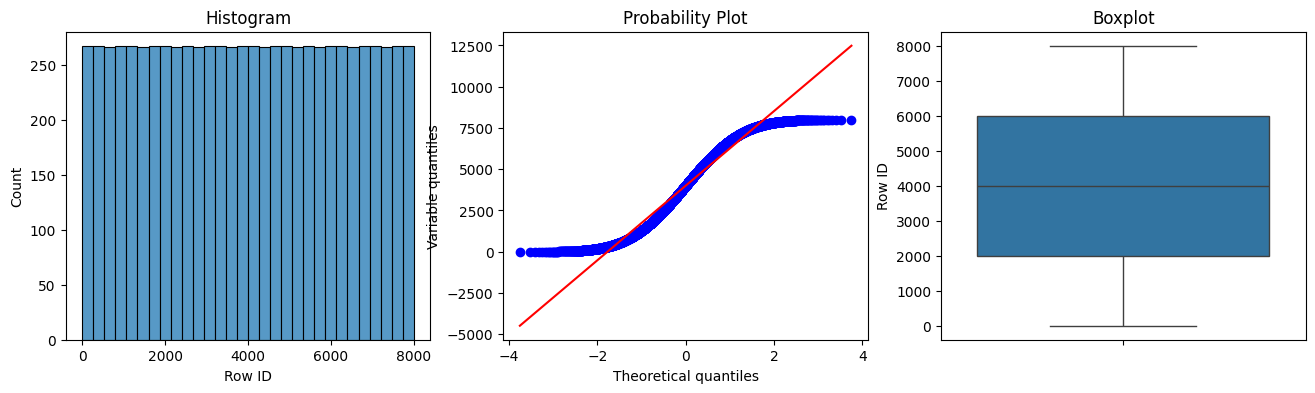

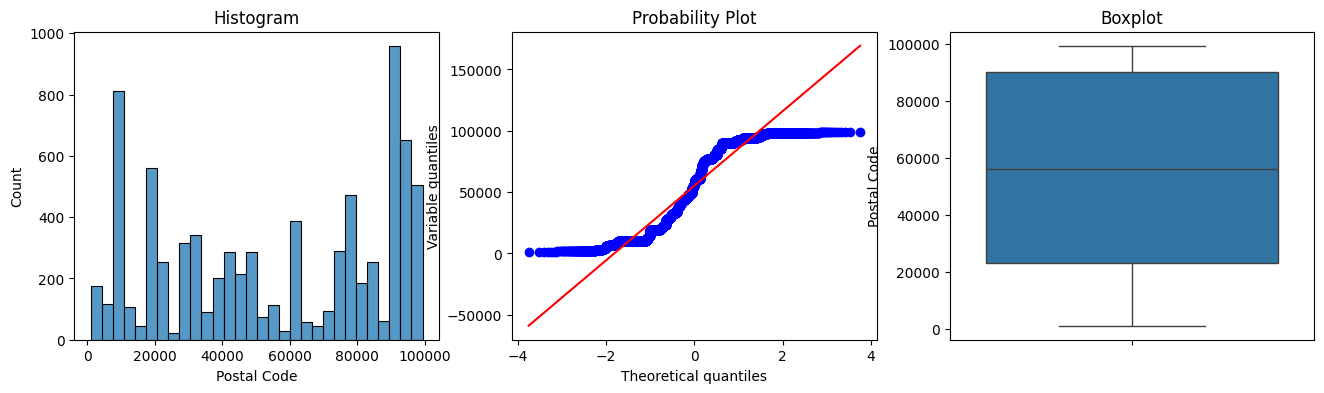

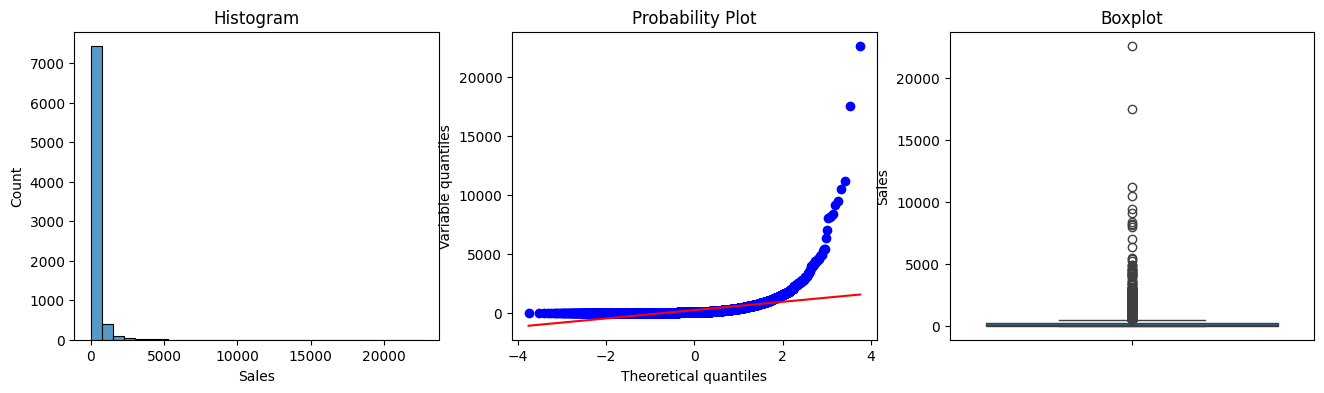

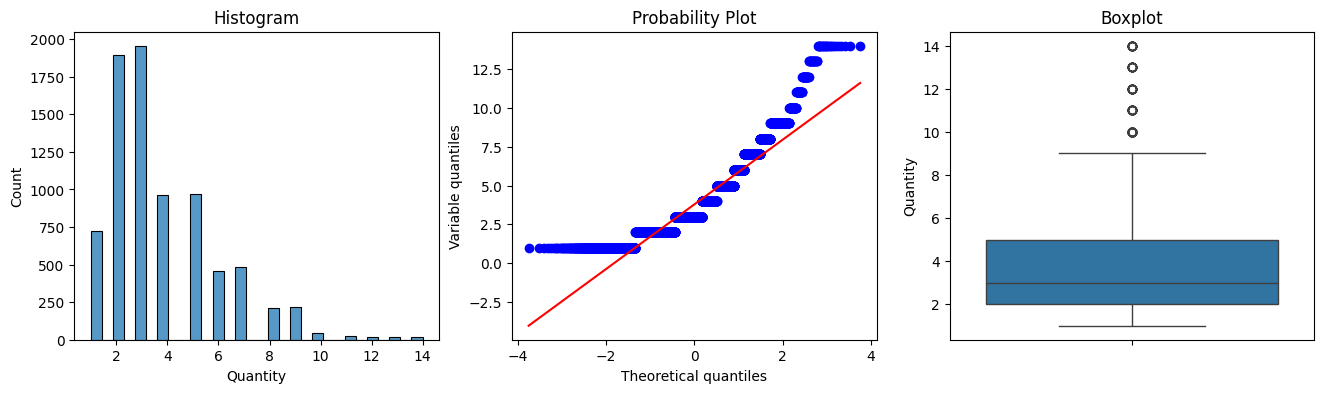

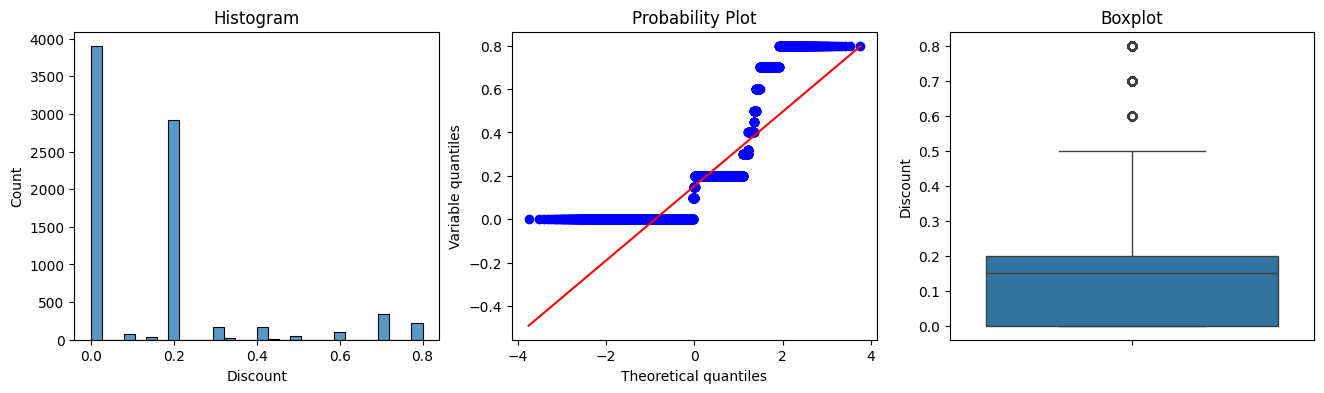

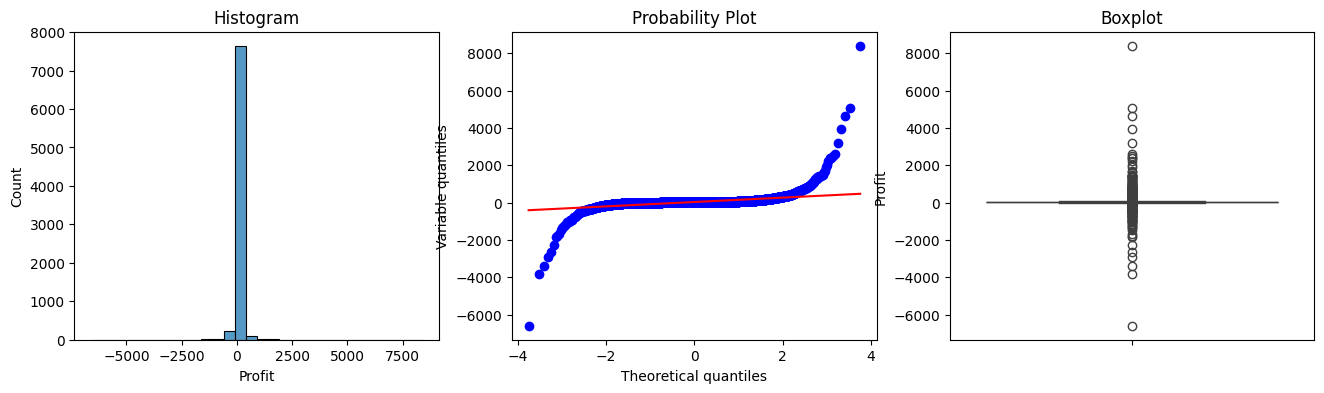

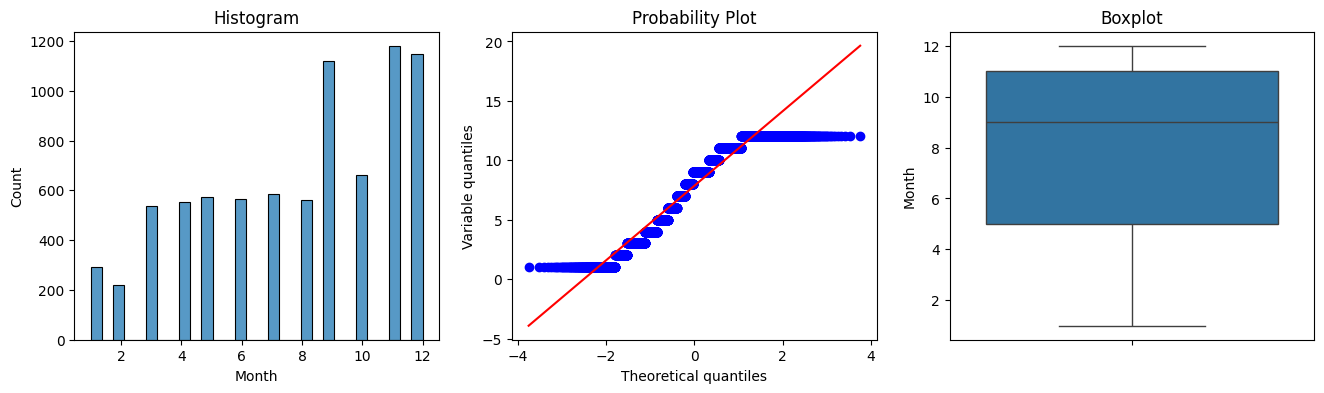

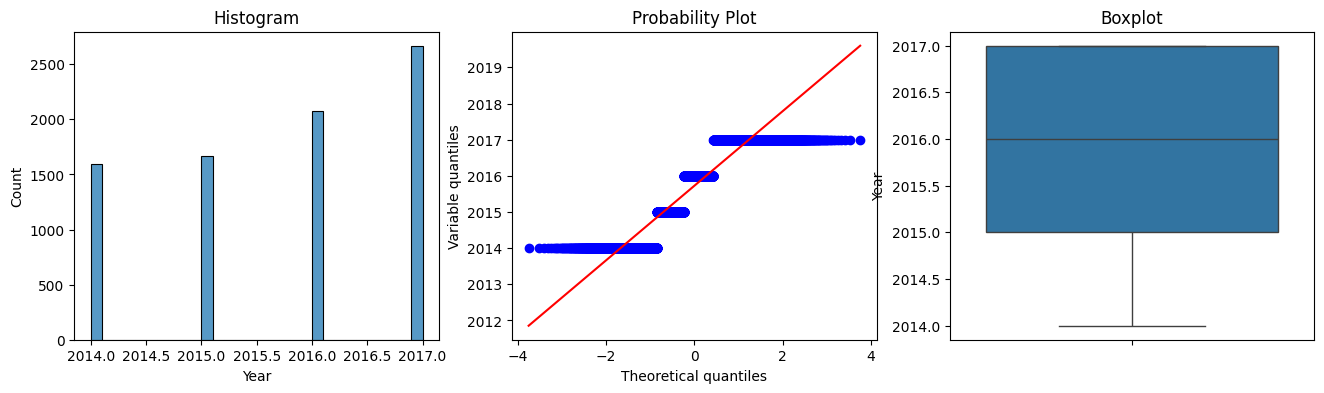

In [ ]:
# handle outlier
import scipy.stats as stats

# mendefinisikan fungsi check_plot untuk melihat outlier dalam 3 bentuk visualisasi
def check_plot(df, variable):
    # Size image
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title("Histogram")

    # Plot Q-Q
    ax = plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel("Variable quantiles")

    # Box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title("Boxplot")

    plt.show()

for cc in numericals:
    check_plot(df, (cc))

Observasi:
- `Sales`, `Quantity`, `Discount`, dan `Profit` terdeteksi memiliki nilai outlier oleh visualisasi boxplot
- Nilai outlier tersebut merupakan nilai yang wajar, sehingga tetap dipertahankan untuk tujuan EDA (Exploratory Data Analysis)

# Questions

### Question 1

Hitunglah total revenue, jumlah order, dan jumlah barang yang terjual sepanjang tahun 2017. Selain itu, hitung rata-rata jumlah barang yang dibeli per transaksi dan rata-rata spending per transaksi.

#### 2017: Total Revenue, Jumlah Order, dan Jumlah Barang Terjual

In [ ]:
# revenue adalah menghitung jumlah uang yang diterima oleh perusahaan
# membuat kolom revenue dengan memperhitungkan diskon
df['Revenue'] = df['Sales'] * (1 - df['Discount']) * df['Quantity']

In [ ]:
# melakukan filter untuk tahun 2017
df_2017 = df[df['Year'] == 2017]

# menambahkan kolom bulan pada data df_2017
df_2017['Month (2017)'] = df_2017['Order Date'].dt.to_period('M')

# group dan agregasi pada revenue, order id, dan quantity berdasarkan bulan di tahun 2017
summary_per_bulan = df_2017.groupby('Month (2017)').agg({
    'Revenue': 'sum',
    'Order ID': pd.Series.nunique,
    'Quantity': 'sum'
}).rename(columns={
    'Revenue': 'Total Revenue',
    'Order ID': 'Jumlah Order',
    'Quantity': 'Jumlah Barang Terjual'
}).reset_index()

# convert kolom month menjadi datetime agar bisa diurutkan
summary_per_bulan['Month (2017)'] = summary_per_bulan['Month (2017)'].dt.to_timestamp()
summary_per_bulan = summary_per_bulan.sort_values('Month (2017)')

summary_per_bulan

<ipython-input-20-bc66bc917772>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017['Month (2017)'] = df_2017['Order Date'].dt.to_period('M')


Month (2017)  Total Revenue  Jumlah Order  Jumlah Barang Terjual
0    2017-01-01  123312.968200            53                    430
1    2017-02-01   62216.615000            43                    289
2    2017-03-01  146655.963308            87                    686
3    2017-04-01  104204.389607            96                    620
4    2017-05-01  144400.920048            87                    681
5    2017-06-01  161483.851225           109                    759
6    2017-07-01  147186.853550            88                    691
7    2017-08-01  275382.586000            91                    736
8    2017-09-01  303939.038900           182                   1378
9    2017-10-01  278060.542718           120                    948
10   2017-11-01  444309.829626           199                   1454
11   2017-12-01  298558.496558           186                   1413

Observasi:
- 2017 adalah tahun terakhir pada data history penjualan dan tercatat rampung hingga bulan ke-12
- Tren jumlah transaksi di tiap bulan mengalami fluktuasi yang stabil. Setelah dua bulan awal, angka transaksi berada di atas 80
- Rata-rata produk terjual sebanyak 840 barang sementara terdapat rata-rata 112 transaksi dan menghasilkan rata-rata revenue 207.476
- Bulan November menjadi bulan dengan jumlah transaksi tertinggi di atas rata-rata, total revenue dan jumlah barang terbanyak dengan detail berikut:
 1. Total Revenue: 444309.829626
 2. Jumlah Order: 199 transaksi
 3. Jumlah Barang Terjual: 1.454 barang



#### 2017: Rata-Rata Jumlah Barang Terjual dan Spending per Transaksi

In [ ]:
total_barang = df_2017['Quantity'].sum()
total_revenue = df_2017['Revenue'].sum()
total_order = df_2017['Order ID'].nunique()

# perhitungan mencari rata-rata jumlah barang terjual dan spending per transaksi
avg_qty_per_order = total_barang / total_order
avg_spending_per_order = total_revenue / total_order

print(f'Rata-rata jumlah barang per transaksi tahun 2017: {avg_qty_per_order:.2f}')
print(f'Rata-rata spending per transaksi tahun 2017: {avg_spending_per_order:.2f}')

Rata-rata jumlah barang per transaksi tahun 2017: 7.52
Rata-rata spending per transaksi tahun 2017: 1856.61


Observasi:
- Tahun 2017 memiliki rata-rata jumlah barang terjual per transaksi sebanyak 7 barang
- Sementara rata-rata spending per transaksi adalah 1.857

### Question 2

Hitunglah jumlah order dan GMV yang diperoleh dengan rentang waktu berikut:
- Harian
- Mingguan
- Bulanan
<br>

*Catatan: GMV dihitung berdasarkan total spending yang dilakukan customer dengan memperhitungkan semua biaya dan diskon yang dibayarkan customer.*

In [ ]:
# GMV adalah jumlah pengeluaran yang dilakukan oleh customer
# perhitungan GMV memiliki catatan memperhitungkan semua biaya dan diskon
# namun pada data tidak tercatat biaya tambahan seperti ongkir pengiriman dan biaya-biaya lainnya
# oleh karena itu, GMV diasumsikan memiliki nilai yang sama dengan Revenue yang hanya memperhitungkan diskon

# membuat kolom GMV
df['GMV'] = df['Revenue']

#### Harian

In [ ]:
harian = df.groupby(df['Order Date'].dt.date).agg({
    'GMV': 'sum',
    'Order ID': pd.Series.nunique
}).rename(columns={
    'Order Date': 'Harian',
    'GMV': 'GMV',
    'Order ID': 'Jumlah Order'
}).reset_index()

harian.head()

Order Date         GMV  Jumlah Order
0  2014-01-03     26.3168             1
1  2014-01-04    684.2640             1
2  2014-01-05     46.8864             1
3  2014-01-06  28430.7800             3
4  2014-01-07    106.6756             1

Observasi:
- Dalam rentang harian, rata-rata GMV adalah 6.648,25 sementara median sebesar 2968.74. Hal ini menunjukkan bahwa terdapat beberapa hari yang memiliki GMV yang sangat tinggi sehingga mempengaruhi hasil rata-rata
- GMV tertinggi terjadi di tahun 2014 pada tangal 18 Maret yaitu sebesar 97.531, namun memiliki jumlah order yang sangat sedikit yaitu sebanyak 3 transaksi
- Rata-rata jumlah order adalah sebanyak 3 transaksi. Transaksi tertinggi terjadi di tahun 2016 tanggal 5 September dengan 18 total order yang menghasilkan GMV 15.699,83

#### Mingguan

In [ ]:
df['Minggu'] = df['Order Date'].dt.to_period('W').apply(lambda r: r.start_time)

mingguan = df.groupby('Minggu').agg({
    'GMV': 'sum',
    'Order ID': pd.Series.nunique
}).rename(columns={
    'GMV': 'GMV',
    'Order ID': 'Jumlah Order'
}).reset_index()

mingguan.head()

Minggu          GMV  Jumlah Order
0 2013-12-30    757.46720             3
1 2014-01-06  28701.99600             7
2 2014-01-13  21346.19685             8
3 2014-01-20  17515.54580             5
4 2014-01-27   4855.61460             6

Observasi:
- Dalam rentang mingguan, rata-rata GMV adalah sebesar 37.567,40 dengan median 27.807,18. Hal ini menunjukkan bahwa terdapat beberapa minggu yang memiliki GMV yang sangat tinggi sehingga mempengaruhi hasil rata-rata
- GMV tertinggi terjadi di minggu ke-201 yang berada di bulan Oktober tahun 2017 dengan GMV 143.008,41 dan memiliki jumlah order yang cukup tinggi yaitu sebanyak 41 transaksi
- Transaksi paling banyak terjadi di minggu ke 203 dan 205 yang berada di tahun 2017 pada bulan November yaitu sebanyak 54 transaksi

#### Bulanan

In [ ]:
df['bulan'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()

bulanan = df.groupby('bulan').agg({
    'GMV': 'sum',
    'Order ID': pd.Series.nunique
}).rename(columns={
    'GMV': 'GMV',
    'Order ID': 'Jumlah Order'
}).reset_index()

bulanan.head()

bulan           GMV  Jumlah Order
0 2014-01-01   70301.67045            27
1 2014-02-01   14306.86320            17
2 2014-03-01  179793.05730            54
3 2014-04-01  102803.44365            51
4 2014-05-01   73994.53750            56

Observasi:
- Dalam rentang waktu bulanan, penjualan menghasilkan rata-rata GMV sebesar 163.574,75 sementara rata-rata jumlah order adalah 82 transaksi
- Bulan November tahun 2017 menjadi bulan yang memperoleh GMV sekaligus jumlah transaksi tertinggi di atas rata-rata. GMV yang dihasilkan adalah sebanyak 444.309,82 dan terjadi 199 total transaksi

### Question 3

Tim marketing ingin mengetahui produk apa saja yang paling sering dibeli dalam 1 tahun terakhir. Rencananya, mereka akan mencoba mem-bundling top produk ini untuk meningkatkan penjualan. Identifikasi top 10 produk yang membawa revenue terbesar dalam 3 bulan terakhir dan produk apa saja yang bisa di-bundling berdasarkan hasil analisis.

#### 1 Tahun Terakhir: Top 10 Produk Terlaris

In [ ]:
# mengambil tanggal terakhir
last_date = df['Order Date'].max()

# memperoleh data dalam 1 tahun terakhir
batas_awal = last_date - pd.DateOffset(years=1)
df_1tahun = df[df['Order Date'] >= batas_awal]

# menghitung jumlah barang terjual di masing-masing nama produk
# kemudian mengurutkan dari kuantitas tertinggi
produk_terlaris = df_1tahun.groupby('Product Name')['Quantity'].sum().sort_values(ascending=False).reset_index()

print(f'Produk terlaris dalam 1 tahun terakhir:')
produk_terlaris.head(10)


Produk terlaris dalam 1 tahun terakhir:


Product Name  Quantity
0                                          Staples        64
1                          Staples in misc. colors        50
2                                  Staple envelope        37
3                                Easy-staple paper        37
4                          Storex Dura Pro Binders        32
5  Logitech Desktop MK120 Mouse and keyboard Combo        29
6                       Avery Durable Poly Binders        28
7                 Crayola Anti Dust Chalk, 12/Pack        27
8               Adjustable Depth Letter/Legal Cart        27
9                 Satellite Sectional Post Binders        27

Observasi:
- Dalam 1 tahun terakhir, produk yang sering dibeli adalah Staples yaitu sebanyak 64 barang
- 4 barang teratas yang banyak dibeli merupakan produk staple


#### 3 Bulan Terakhir: Top 10 Produk Revenue Terbesar dan Rekomendasi Bundling

In [ ]:
# mengambil tanggal terakhir
last_date = df['Order Date'].max()

# mengambil data 3 bulan terakhir
batas_awal = last_date - pd.DateOffset(months=3)
df_3bulan = df[df['Order Date'] >= batas_awal]

# menghitung jumlah revenue di setiap produk kemudian diurutkan dari yang tertinggi
produk_teruntung = df_3bulan.groupby('Product Name')['Revenue'].sum().sort_values(ascending=False).reset_index()

print(f'Produk dengan revenue terbesar dalam 3 bulan terakhir:')
# membatasi hanya pada 10 produk teratas
top10_produk_teruntung = produk_teruntung.head(10)
top10_produk_teruntung


Produk dengan revenue terbesar dalam 3 bulan terakhir:


Product Name     Revenue
0              Canon imageCLASS 2200 Advanced Copier  67339.8076
1  Acco 7-Outlet Masterpiece Power Center, Wihtou...  25074.6592
2                      Hon 94000 Series Round Tables  23990.5800
3                 Adjustable Depth Letter/Legal Cart  22726.0504
4  Kensington 7 Outlet MasterPiece HOMEOFFICE Pow...  22159.2800
5                                     Google Nexus 5  21778.7900
6   3D Systems Cube Printer, 2nd Generation, Magenta  20799.8400
7                      Logitech diNovo Edge Keyboard  20249.1900
8             Iceberg Mobile Mega Data/Printer Cart   19252.8000
9                  Polycom CX600 IP Phone VoIP phone  19196.8000

In [ ]:
# alur menemukan rekomendasi bundling
from collections import Counter
from itertools import combinations

top10_produk_teruntung= top10_produk_teruntung['Product Name'].to_list()

# mengambil Order ID yang mengandung produk top 10
df_top_orders = df_3bulan[df_3bulan['Product Name'].isin(top10_produk_teruntung)]

# membuat grup produk per transaksi
produk_per_order = df_top_orders.groupby('Order ID')['Product Name'].unique()


# menghitung pasangan produk yang sering dibeli secara bersamaan
pair_counter = Counter()
for produk_list in produk_per_order:
    produk_list = sorted(produk_list)
    for pair in combinations(produk_list, 2):
        pair_counter[pair] += 1

# mengambil paket bundling pada urutan top 10
bundling_rekomendasi = []
for pair, count in pair_counter.most_common(10):
    if pair[0] in top10_produk_teruntung or pair[1] in top10_produk_teruntung:
        bundling_rekomendasi.append((pair[0], pair[1], count))

# membuat dataframe
df_bundling = pd.DataFrame(bundling_rekomendasi, columns=['Produk A', 'Produk B', 'Dibeli Bersama'])


In [ ]:
df_bundling

Produk A                           Produk B  \
0  Canon imageCLASS 2200 Advanced Copier  Polycom CX600 IP Phone VoIP phone   

   Dibeli Bersama  
0               1

Observasi:
- 10 barang yang memiliki revenue tertinggi dalam 3 bulan terakhir adalah:
 1. Canon imageCLASS 2200 Advanced Copier
 2. Acco 7-Outlet Masterpiece Power Center
 3. Hon 94000 Series Round Tables
 4. Adjustable Depth Letter/Legal Cart
 5. Kensington 7 Outlet MasterPiece HOMEOFFICE
 6. Google Nexus 5
 7. 3D Systems Cube Printer, 2nd Generation, Magenta
 8. Logitech diNovo Edge Keyboard
 9. Iceberg Mobile Mega Data/Printer Cart
 10. Polycom CX600 IP Phone VoIP phone
- Rekomendasi yang diberikan berdasarkan hasil analisis di atas adalah memberikan bundling pada produk Canon imageCLASS 2200 Advanced Copier dan Polycom CX600 IP Phone VoIP phone. Keduanya termasuk ke dalam top 10 produk yang terjual dan menghasilkan revenue tertinggi dan telah dibeli secara bersamaan sebanyak 2 kali dalam 3 bulan terakhir

### Question 4

Identifikasi top 5 kota yang memiliki order terbanyak dan 5 kota yang memiliki total dan rata-rata spending terbesar.

#### Top 5 Kota: Order Terbanyak

In [ ]:
# top 5 kota dengan total order terbanyak
top5_order = df.groupby('City')['Order ID'].nunique().sort_values(ascending=False).head()
top5_order = top5_order.reset_index(name='Total Order')
top5_order

City  Total Order
0  New York City          362
1    Los Angeles          306
2   Philadelphia          209
3  San Francisco          208
4        Seattle          170

Observasi:
- 5 Kota yang memiliki transaksi terbanyak adalah berada di New York City (362), Los Angeles (306), Philadelphia (209), San Fransisco (208), dan Seattle (170)

#### Top 5 Kota: Total dan Rata-Rata Spending Terbesar

In [ ]:
# menghitung total dan rata-rata spending
top_spending = df.groupby('City').agg(
    Total_GMV=('GMV', 'sum'),
    Avg_GMV=('GMV', 'mean')
)

# mengambil data hanya pada kuartil atas
threshold_total = top_spending['Total_GMV'].quantile(0.75)
threshold_avg = top_spending['Avg_GMV'].quantile(0.75)

# memilih kota yang memenuhi kriteria threshold
top_5_combined = top_spending[(top_spending['Total_GMV'] >= threshold_total) &
                               (top_spending['Avg_GMV'] >= threshold_avg)]

# mengambil 5 kota teratas
top_5_combined = top_5_combined.sort_values(by=['Total_GMV', 'Avg_GMV'], ascending=False).head(5)

top_5_combined.reset_index()


City    Total_GMV      Avg_GMV
0  New York City  910842.8495  1225.898855
1        Seattle  392235.4836  1167.367511
2      San Diego  178258.6641  1255.342705
3    Springfield  155205.3215  1124.676243
4   Jacksonville  128234.8052  1269.651537

Observasi:
- Tidak semua 5 kota teratas dengan order terbanyak memiliki total dan rata-rata spending yang banyak pula
- Kota New York City dan Seattle merupakan kota dengan jumlah transaksi terbanyak sekaligus menghasilkan total dan rata-rata spending yang besar
- Rata-rata spending di setiap kota hampir sama dan hanya memiliki selisih yang sedikit yang berada di rentang angka 1100 - 1200 an, namun total spending saling berbeda sangat jauh

### Question 5

Buatlah model forecasting menggunakan model yang sudah diajarkan pada materi untuk memprediksi jumlah visitor dan jumlah transaksi untuk 1 bulan ke depan dengan data harian. Anda diharuskan setidaknya membuat 2 model untuk selanjutnya diambil model terbaik berdasarkan MAPE terkecil. Berikan rekomendasi apa yang perlu dilakukan tim bisnis berdasarkan hasil forecasting dan analisis Anda.

#### Build Dataset: Jumlah Transaksi

*Prediksi hanya dilakukan pada jumlah transaksi dan tidak pada jumlah visitor karena data yang tersedia hanya terbatas mencakup data penjualan saja*

In [ ]:
# membuat dataset jumlah transaksi harian
data_forecasting = df.groupby('Order Date')['Order ID'].nunique().reset_index()
data_forecasting.columns = ['Order Date', 'Jumlah Transaksi']
data_forecasting.head()

Order Date  Jumlah Transaksi
0 2014-01-03                 1
1 2014-01-04                 1
2 2014-01-05                 1
3 2014-01-06                 3
4 2014-01-07                 1

In [ ]:
data_forecasting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181 entries, 0 to 1180
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order Date        1181 non-null   datetime64[ns]
 1   Jumlah Transaksi  1181 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 18.6 KB


#### Descriptive Statistics

In [ ]:
data_forecasting.describe()

Order Date  Jumlah Transaksi
count                           1181       1181.000000
mean   2016-01-25 13:38:09.246401280          3.354784
min              2014-01-03 00:00:00          1.000000
25%              2015-01-09 00:00:00          2.000000
50%              2016-02-07 00:00:00          3.000000
75%              2017-01-23 00:00:00          4.000000
max              2017-12-30 00:00:00         18.000000
std                              NaN          2.375786

#### Checking Duplicate

In [ ]:
len(data_forecasting.drop_duplicates())/len(data_forecasting)

1.0

Observasi:
- Tidak ditemukan nilai yang duplikat

#### Checking Missing Value

In [ ]:
data_forecasting.isnull().sum()

Order Date          0
Jumlah Transaksi    0
dtype: int64

Observasi:
- Tidak ditemukan missing value

#### Set Index: Kolom Order Date

In [ ]:
# menjadikan kolom order date sebagai index untuk memudahkan analisis ke depannya
data_forecasting = data_forecasting.set_index("Order Date")

#### Mengidentifikasi Pola

##### Pola Harian

In [ ]:
Harian = data_forecasting.copy()
Harian['Weekday'] = Harian.index.day_name()

In [ ]:
Weekday_Avg = Harian.groupby('Weekday')['Jumlah Transaksi'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

In [ ]:
Weekday_Avg = Weekday_Avg.reset_index()
Weekday_Avg.columns = ['Weekday', 'Jumlah Transaksi']

In [ ]:
Weekday_Avg

Weekday  Jumlah Transaksi
0     Monday          3.833333
1    Tuesday          2.633540
2  Wednesday          1.477778
3   Thursday          3.751634
4     Friday          3.730570
5   Saturday          3.447761
6     Sunday          3.570681

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Jumlah Transaksi'>)

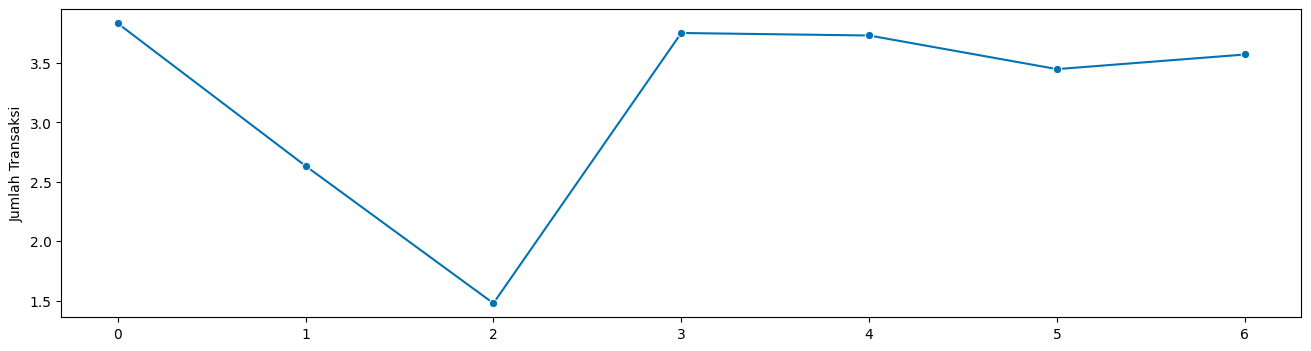

In [ ]:
plot_series(Weekday_Avg['Jumlah Transaksi'])

Observasi: <br>
Rata-rata pola harian menunjukkan transaksi tertinggi terjadi di hari senin yaitu sebanyak 4 transaksi. Kemudian menurun signifikan dalam 2 hari berikutnya. Tren kembali melonjak naik di hari kamis dan mengalami fluktuasi yang stabil setelahnya

##### Pola Mingguan

In [ ]:
Mingguan = data_forecasting.copy()
Mingguan = Mingguan.resample('W')['Jumlah Transaksi'].sum().reset_index()
Mingguan.head()

Order Date  Jumlah Transaksi
0 2014-01-05                 3
1 2014-01-12                 7
2 2014-01-19                 8
3 2014-01-26                 5
4 2014-02-02                 6

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Jumlah Transaksi'>)

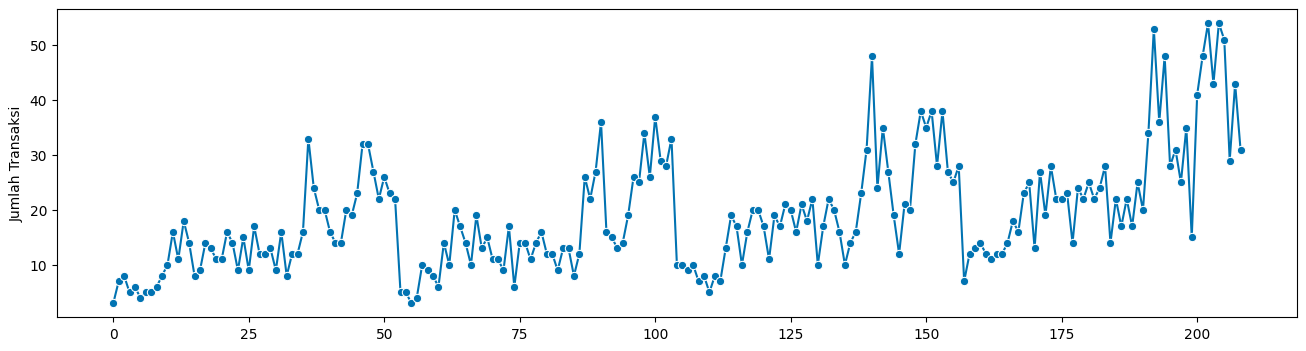

In [ ]:
plot_series(Mingguan['Jumlah Transaksi'])

Observasi: <br>
Ditemukan pola yang sama yang terus berulang di setiap 50 minggu. Seiring bertambahnya minggu, pola yang sama mengalami pertumbuhan jumlah transaksi

##### Pola Musiman: Bulanan, Tahunan, dan Seasonal Decompose

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Jumlah Transaksi'>)

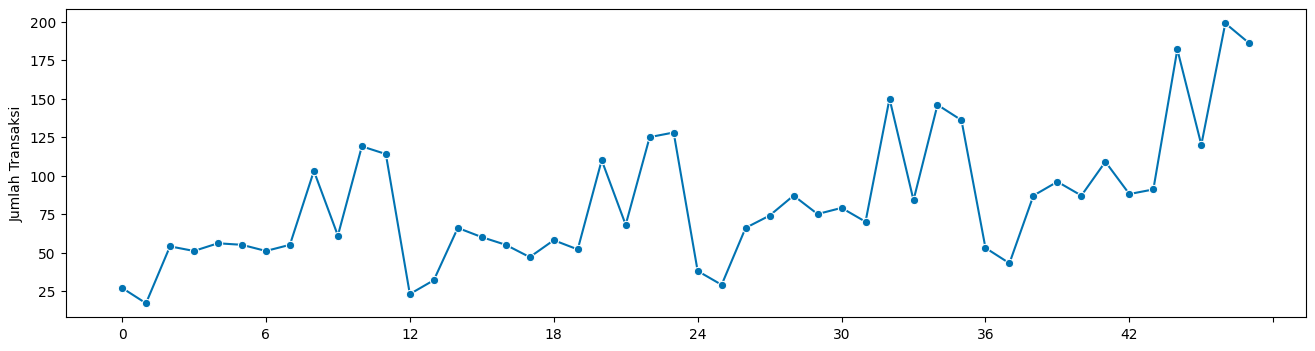

In [ ]:
# pola musiman: bulanan
Bulanan = data_forecasting.copy()
Bulanan = Bulanan.resample('M')['Jumlah Transaksi'].sum().reset_index()
plot_series(Bulanan['Jumlah Transaksi'])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Jumlah Transaksi'>)

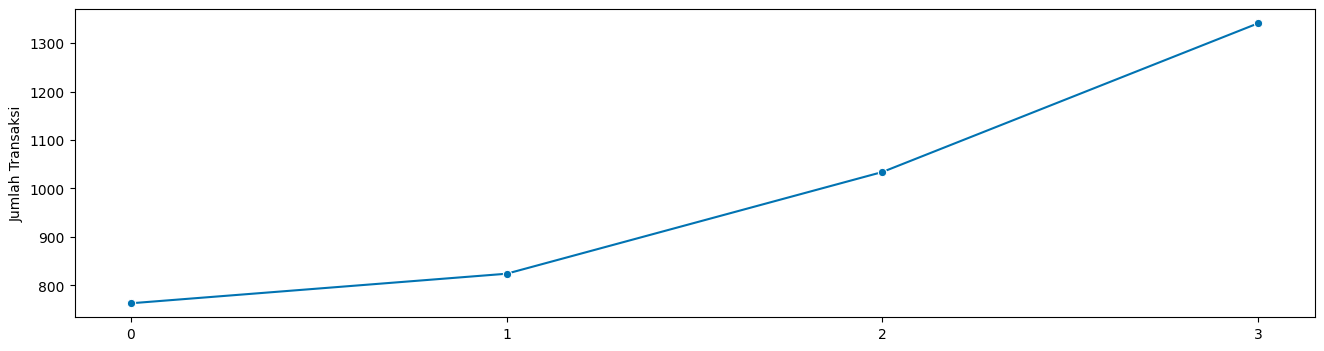

In [ ]:
# pola musiman: tahunan
Tahunan = data_forecasting.copy()
Tahunan = Tahunan.resample('A')['Jumlah Transaksi'].sum().reset_index()
plot_series(Tahunan['Jumlah Transaksi'])

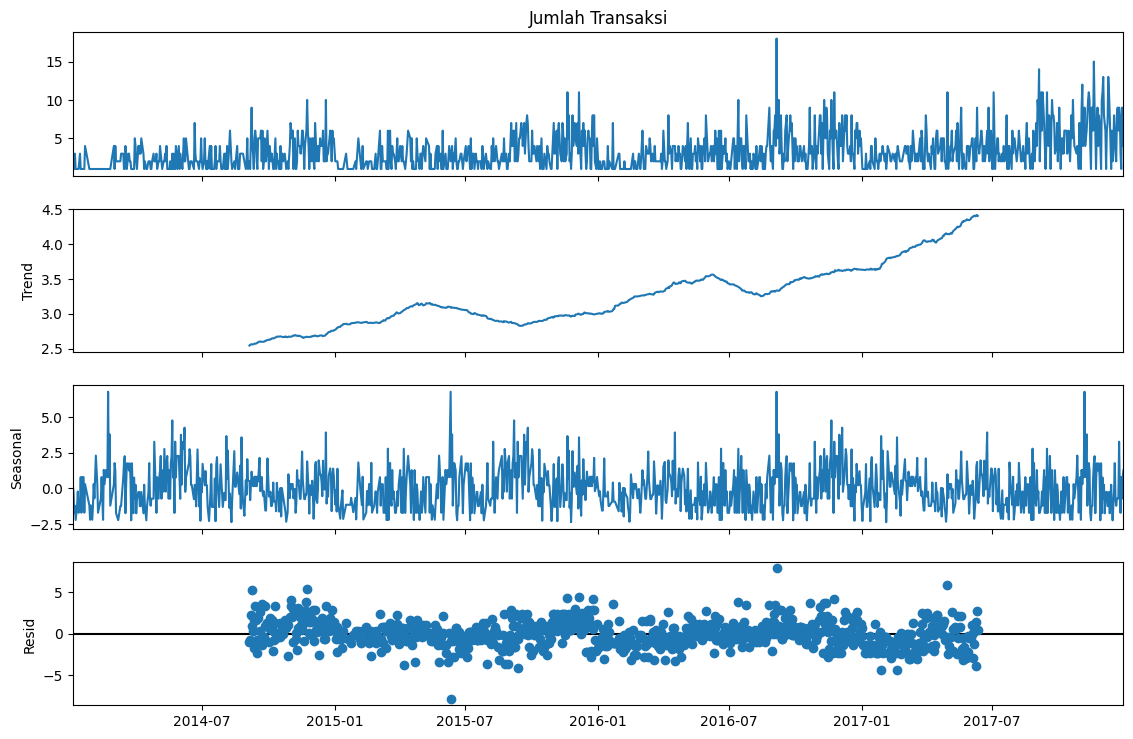

In [ ]:
# pola musiman: seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal = data_forecasting.copy()

# melakukan seasonal decompose
result = seasonal_decompose(seasonal['Jumlah Transaksi'], model='Multiplicative', period=365)

# menampilkan hasil seasonal decompose
fig = result.plot()
fig.set_size_inches(12,8)

plt.show()


Observasi:
- Pola bulanan menunjukkan terjadi pola yang sama dan terus berulang di setiap 12 bulan
- Tren tiap tahun tidak menampilkan pola perulangan namun hanya menunjukkan tren yang terus meningkat
- Seasonal decompose menggunakan model multiplicative karena pertumbuhan yang terjadi di setiap pola kian meningkat secara signifikan. Periode yang ditampilkan adalah harian yang menunjukkan terdapat seasonal period dan kenaikan tren yang meningkat seiring waktu

#### Handle Outlier

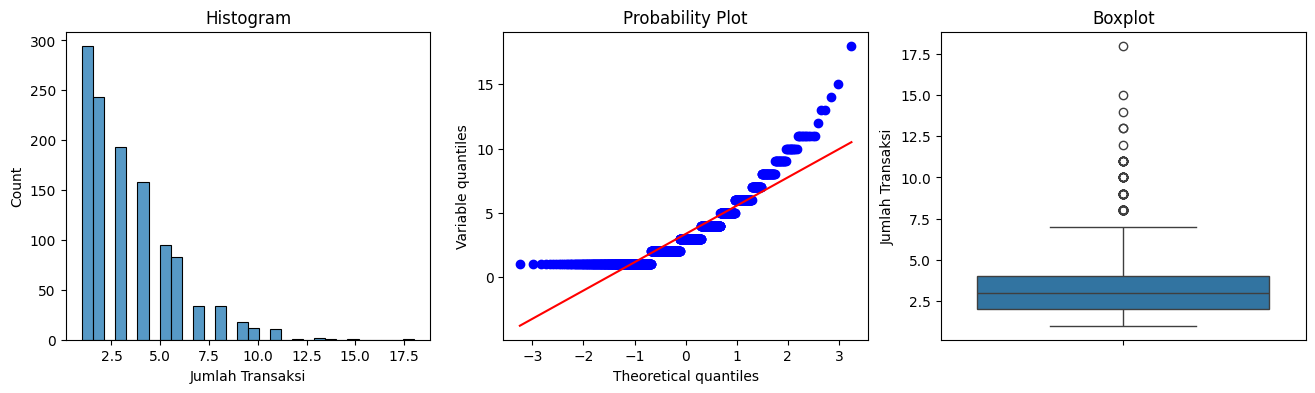

In [ ]:
# check outlier
check_plot(data_forecasting, ('Jumlah Transaksi'))

In [ ]:
data_forecasting['Jumlah Transaksi'] = np.log1p(data_forecasting['Jumlah Transaksi'])

Observasi:
- Ditemukan outlier pada kolom `Jumlah Transaksi`
- Karena salah satu model yang akan digunakan adalah NaiveForecaster yang sensitif terhadap nilai ekstrem, maka outlier dihandle menggunakan metode log transform


#### Checking ACF & PACF

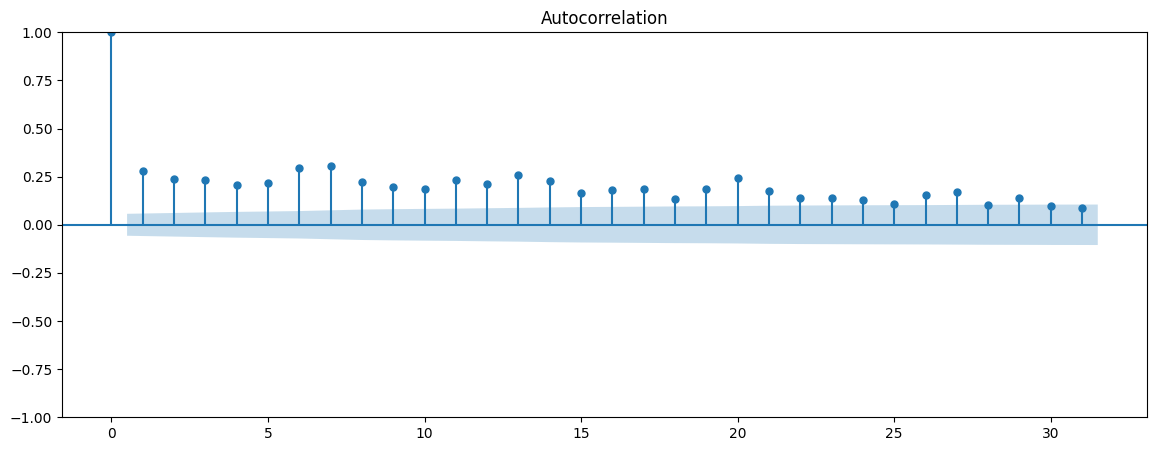

In [ ]:
plot_acf(data_forecasting['Jumlah Transaksi']).set_size_inches((14,5))

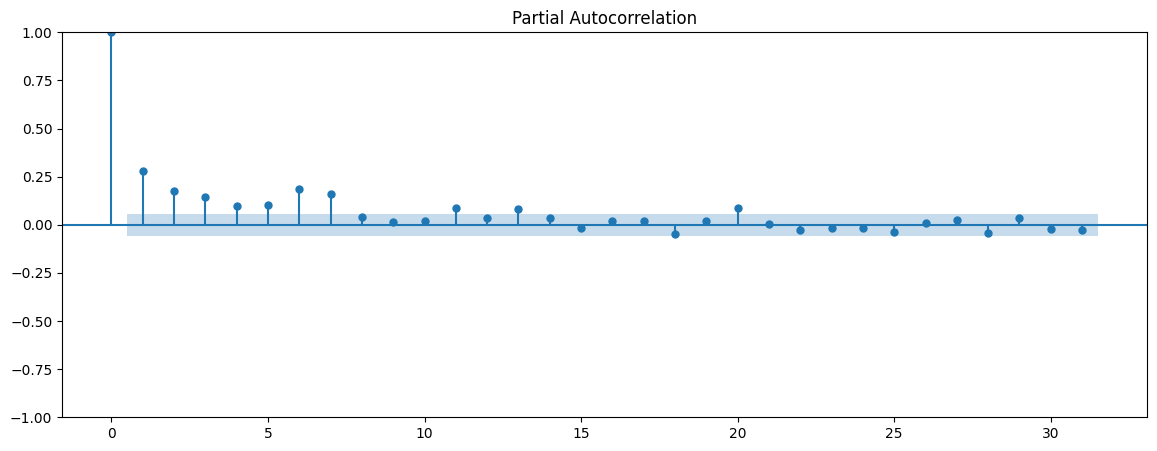

In [ ]:
plot_pacf(data_forecasting['Jumlah Transaksi']).set_size_inches((14,5))

#### Split Data

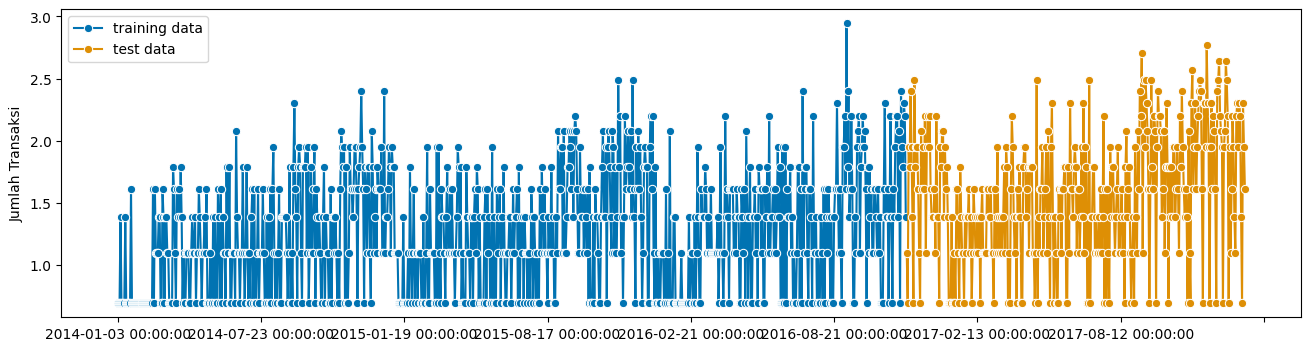

In [ ]:
# Split data
# melakukan pembagian data dengan presentase 30% untuk data test

y_train, y_test = temporal_train_test_split(data_forecasting['Jumlah Transaksi'], test_size = 0.3)
plot_series(y_train, y_test, labels=["training data", "test data"])

# tidak seluruh hari tercatat pada data
# sehingga perlu mengatur frekuensi time series menjadi harian tanpa mengisi data yang hilang
y_train = y_train.asfreq('D')
y_test = y_test.asfreq('D')

# data yang bernilai NaN ditangani dengan metode interpolate
y_train = y_train.interpolate(method='time')
y_test = y_test.interpolate(method='time')

Observasi:
- Pembagian data menjadi train dan test menggunakan perbandingan 70:30 karena data cenderung stabil dan dapat belajar dengan baik di sebagian data. Pola musiman yang dimiliki juga tidak terlalu kompleks sehinga tidak perlu belajar banyak dari data train
- Tanggal pada data tidak tercatat di seluruh harinya sehingga perlu mengatur frekuensi time series
- Data yang bernilai NaN dihandle dengan metode interpolate. Interpolate akan mengisi nilai NaN dengan pertengahan angka antara sebelum dan setelahnya sehingga tidak mengacaukan pola

#### Build Model: Naive

In [ ]:
# model naive forecaster
# mengatur sp dan window_lenght sebesar 365 hari karena pola yang terjadi adalah tahunan
naive_forecaster = NaiveForecaster(strategy='mean', sp=365, window_length=365)
naive_forecaster.fit(y_train)

NaiveForecaster(sp=365, strategy='mean', window_length=365)

In [ ]:
fh  = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = naive_forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Jumlah Transaksi'>)

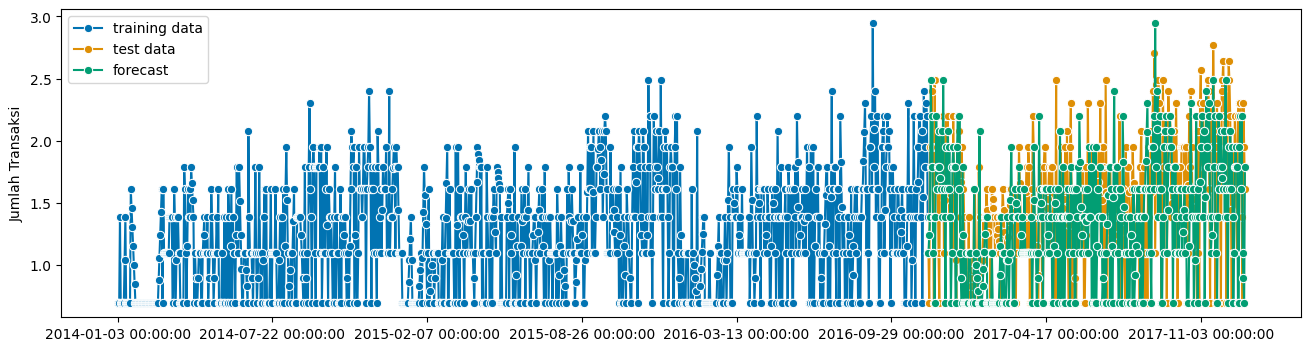

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["training data", "test data", "forecast"])

In [ ]:
# Mean Absolute Percentage Error
mean_absolute_percentage_error(y_test, y_pred) * 100

34.32915290972606

Observasi:<br>
Model Naive Forecaster yang menjadi baseline memiliki MAPE 34,32%, yang menunjukkan performa yang cukup baik yaitu di bawah 50%

#### Build Model: Prophet

In [ ]:
# model Prophet
fh = ForecastingHorizon(y_test.index, is_relative=False)

prophet_model = Prophet()
prophet_model.fit(y_train)
y_pred = prophet_model.predict(fh)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk4xya1rs/ce27zyb_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk4xya1rs/7tw49za_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68687', 'data', 'file=/tmp/tmpk4xya1rs/ce27zyb_.json', 'init=/tmp/tmpk4xya1rs/7tw49za_.json', 'output', 'file=/tmp/tmpk4xya1rs/prophet_model8zfdgk5m/prophet_model-20250522061249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Jumlah Transaksi'>)

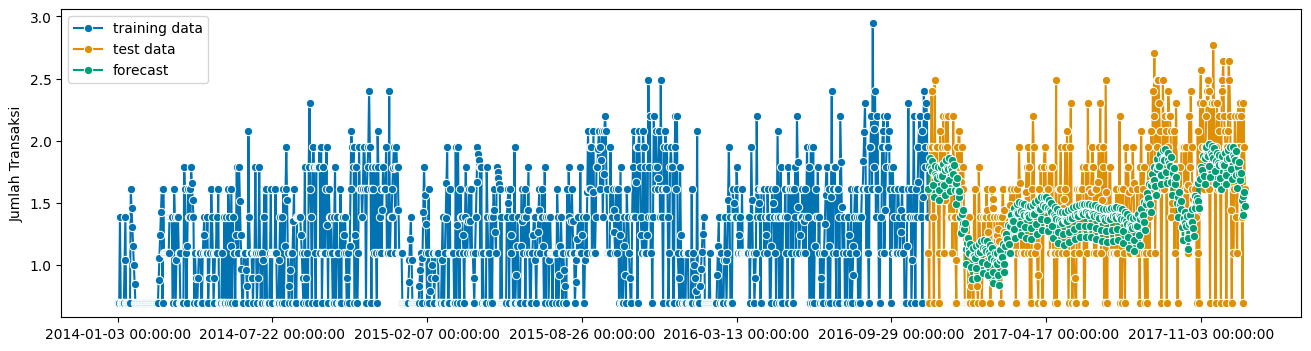

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["training data", "test data", "forecast"])

In [ ]:
# Mean Absolute Percentage Error
mean_absolute_percentage_error(y_test, y_pred) * 100

28.178845619755077

Observasi: <br>
Model Prophet memiliki performa lebih baik daripada model sebelumnya yaitu Naive Forecaster yang menjadi baseline. Model memiliki MAPE sebesar 28,17%. Oleh karena itu, model yang digunakan untuk memprediksi jumlah transaksi dalam 1 bulan ke depan adalah Prophet

#### Prediksi dengan Model Prophet: Bagaimana Transaksi dalam 1 bulan ke depan?

In [ ]:
# retrain model prophet menggunakan data keseluruhan
y = data_forecasting['Jumlah Transaksi']

# mengatur frekuensi time series dan handle nilai NaN dengan metode interpolasi
y = y.asfreq('D')
y = y.interpolate(method='time')

prophet_model.fit(y)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk4xya1rs/65_lon_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk4xya1rs/5t1_ea2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3182', 'data', 'file=/tmp/tmpk4xya1rs/65_lon_y.json', 'init=/tmp/tmpk4xya1rs/5t1_ea2j.json', 'output', 'file=/tmp/tmpk4xya1rs/prophet_modelwaelfkzd/prophet_model-20250522061251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet()

In [ ]:
# membuat data prediksi 1 bulan ke depan
last_date = y.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
fh_future = ForecastingHorizon(future_dates, is_relative=False)

In [ ]:
# memprediksi data
y_forecast_next_month = prophet_model.predict(fh_future)

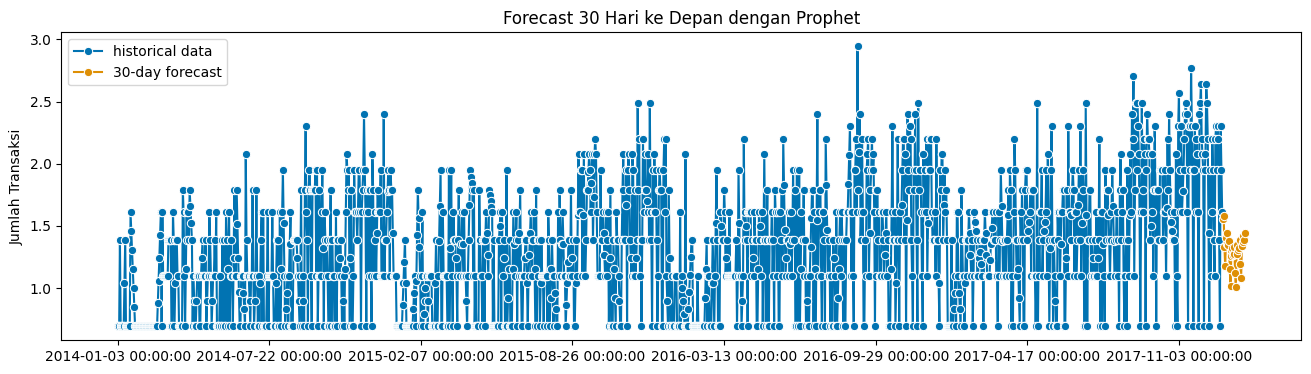

In [ ]:
plot_series(y, y_forecast_next_month, labels=["historical data", "30-day forecast"])
plt.title("Forecast 30 Hari ke Depan dengan Prophet")
plt.show()

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Jumlah Transaksi'>)

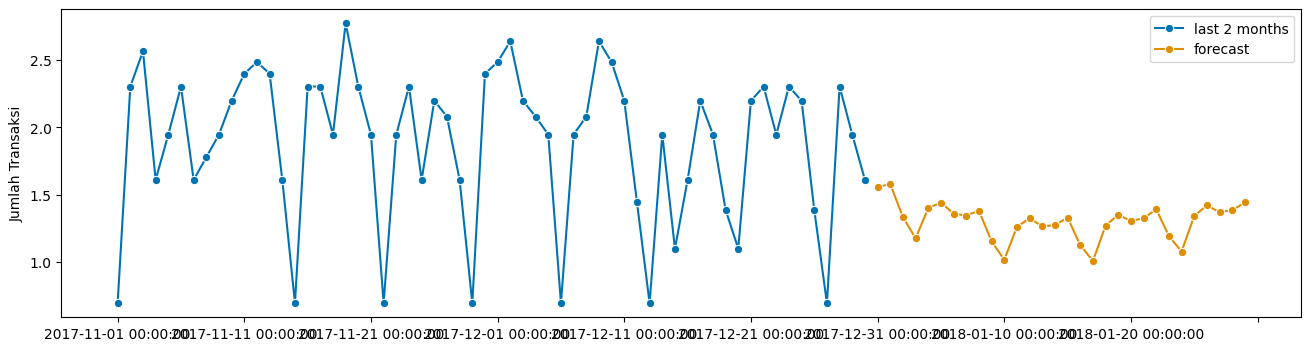

In [ ]:
# menampilkan tren terbatas di 2 bulan terakhir beserta hasil prediksi 1 bulan ke depan
y_last_60 = y[-60:]
plot_series(y_last_60, y_forecast_next_month, labels=["last 2 months", "forecast"])

In [ ]:
# melakukan inverse log transform pada hasil prediksi untuk interpretasi
y_forecast_real = np.expm1(y_forecast_next_month)

In [ ]:
y_forecast_real.index.min(), y_forecast_real.index.max()

(Timestamp('2017-12-31 00:00:00'), Timestamp('2018-01-29 00:00:00'))

In [ ]:
y_forecast_real.mean(), y_forecast_real.median(), y_forecast_real.sum()

(2.725926746335801, 2.7873220265586482, 81.77780239007403)

In [ ]:
y_forecast_real.max(), y_forecast_real.idxmax()

(3.8408632530254767, Timestamp('2018-01-01 00:00:00'))

In [ ]:
y_forecast_real.min(), y_forecast_real.idxmin()

(1.7377035630782223, Timestamp('2018-01-17 00:00:00'))

Observasi:
- Waktu yang diprediksi adalah dalam jangka 1 bulan ke depan, yaitu tanggal 31 Desember 2017 hingga 29 Januari 2018. Diperkirakan akan terjadi sebanyak 82 total transaksi
- Dari hasil analisis diprediksi bahwa transaksi tertinggi akan terjadi di tanggal 1 yaitu terdapat 4 transaksi. Sementara transaksi terendah berada di tanggal 17 yaitu sebanyak 2 transaksi
- Diprediksi bahwa rata-rata transaksi adalah sebanyak 3 transaksi
- Tren memiliki kesamaan pola di setiap minggu dalam periode 1 bulan, yaitu setelah di 2 hari awal (yaitu di hari rabu-kamis) tren melonjak turun signifikan kemudian setelahnya naik kembali (seperti di hari pertama dan kedua) dan memiliki pola fluktuasi stabil di hari berikutnya
- Rekomendasi strategi bisnis:<br>
 1. Meningkatkan aktivitas promosi dan notifikasi di midweek dimana terjadi penurunan penjualan
 2. Meningkatkan engagement dan memastikan e-commerce bekerja optimal di 2 hari awal dan di akhir pekan
 3. Menyesuaikan jumlah staff di hari-hari tertentu, yaitu lebih banyak berada di akhir pekan, dan lebih sedikit di hari ketiga dan keempat
 4. Menjadwalkan optimasi operasional yaitu kegiatan maintanance dilakukan di hari yang sepi